In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score,make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold,StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from matplotlib.colors import ListedColormap

## Problem Statement:
1) In the last years, credit and debit cards usage has significantly increased.However a non negligible part of the credit card transactions are fraudulent and billions of dollers are stolen every year throughout the world.
2) Credit card fraud detection present several characteristics that makes it a
challenging task. 
3) First, purchase behaviours and fraudster strategies may change over time, making a learnt fraud detection decision function irrelevant if not updated.This phenomenon named dataset shift (change in the distribution p(x, y)) may hinder fraud detection systems to obtain good performances.
4) Present case study,agglomarative clustering method with MCC metric is used in order to quantify the day by day dataset shift and identified calendar related time periods that show different properties grouped them into 4 clusters.<br>
5) Second,credit card transactions data suffer from a strong imbalance regarding the class labels which needs to be considered either from the classifier perspective or from the data perspective (less than 1% of the transactions are fraudulent transactions).

## Objective of casestudy:
**The objective of this casestudy is to predict the probability that an online transaction is fraudulent.**

## Dataset link
You can download data from below URL<br>
https://www.kaggle.com/competitions/ieee-fraud-detection/data

## Description of Dataset:
Throughout this work, we study a Vesta-Payment card prevention service dataset containing all the credit card transactions issued by american credit cards for a period of 6 months.<br>
Data is separated into two datasets: information about the customer identity and transaction, joined by TransactionID. Not all transactions have corresponding identity information.

* **Numerical Features - Transaction** <br><br>
    * TransactionDT:timedelta from a given reference datetime (not an actual timestamp) <br>
    * TransactionAMT: transaction payment amount in USD <br>
    * dist: distance <br>
    * C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.<br>
    * D1-D15: timedelta, such as days between previous transaction, etc.<br>
    * Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.<br>
* **Categorical Features** <br><br>
    * ProductCD: product code, the product for each transaction<br>
    * card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.<br>
    * addr1, addr2: address<br>
    * P_emaildomain: purchaser email domain
    * R_emaildomain: recipient email domain
    * M1 - M9: match, such as names on card and address, etc.
* **Explanation on Identity Data**
    * Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
    * They're collected by Vesta’s fraud protection system and digital security partners.(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement).
* **Categorical Features - Identity**
    * DeviceType
    * DeviceInfo
    * id_12 - id_38
* More details about the data: https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203

## Data Preprocessing

* We have total 4 csv files:
    * train_transaction.csv
    * train_identity.csv
    * test_transaction.csv
    * test_identification.csv
* We combine transaction identity tables with key as TransactionID

### Load Data

In [2]:
df_train_transaction=pd.read_csv('train_transaction.csv')
df_train_identity=pd.read_csv('train_identity.csv')
df_test_transaction=pd.read_csv('test_transaction.csv')
df_test_identity=pd.read_csv('test_identity.csv')

In [3]:
'''
test and train columns names are different i.e id_01 in train id-01 in test 
preprocessed it so all columns have same name
'''
new_column_names=[]
for col in df_test_identity.columns:
    if col[0]=='i':
        split=col.split('-')
        new_column_names.append(split[0]+'_'+split[1])
    else:
        new_column_names.append(col)
dictt=dict(zip(df_test_identity.columns,new_column_names))
df_test_identity.rename(dictt,axis=1,inplace=True)

In [4]:
# merge two datasets
df_train = pd.merge(df_train_transaction,df_train_identity, on='TransactionID', how='left')
df_test = pd.merge(df_test_transaction,df_test_identity, on='TransactionID', how='left')

## EDA for Aggregated features over Transactiontime and Transactionamount

### We are creating new features to which help to perform aggregations

In [5]:
'''TransactionDT starts at 86400 which is 24*3600 total number of seconds in a day.
   I am creating new features day,week,week2,month,hour to help analyze volume and 
   amount of transactions. They will be removed before sending the data to model.
'''
df_train['day']=df_train['TransactionDT']//(24*3600)
df_train['week']=df_train['TransactionDT']//(24*3600*7)
df_train['week2']=df_train['TransactionDT']//(24*3600*14)
df_train['month']=df_train['TransactionDT']//(24*3600*30)
df_train['hour']=(df_train['TransactionDT']//3600-24)%24

df_test['day']=df_test['TransactionDT']//(24*3600)
df_test['week']=df_test['TransactionDT']//(24*3600*7)
df_test['week2']=df_test['TransactionDT']//(24*3600*14)
df_test['month']=df_test['TransactionDT']//(24*3600*30)
df_test['hour']=(df_test['TransactionDT']//3600-24)%24

# Exploratory Data Analysis

### TransactionDT distribution

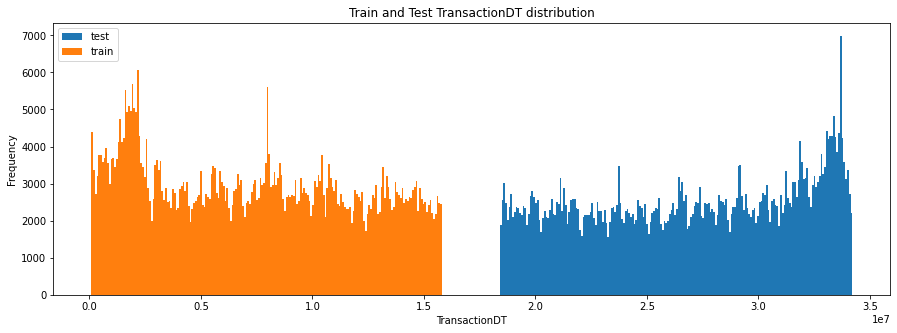

In [6]:
df_test['TransactionDT'].plot(kind='hist', figsize=(15, 5), label='test', bins=200, title='Train and Test TransactionDT distribution')
df_train['TransactionDT'].plot(kind='hist', label='train', bins=200)
plt.xlabel('TransactionDT')
plt.legend()
plt.show()

### Observation:
1) There is a clear seperation of distributions of train and test transactions.
2) TransactionDT is a time feature its value starts from 86400 we can consider units of TransactionDT as seconds.  

### TransactionID distribution

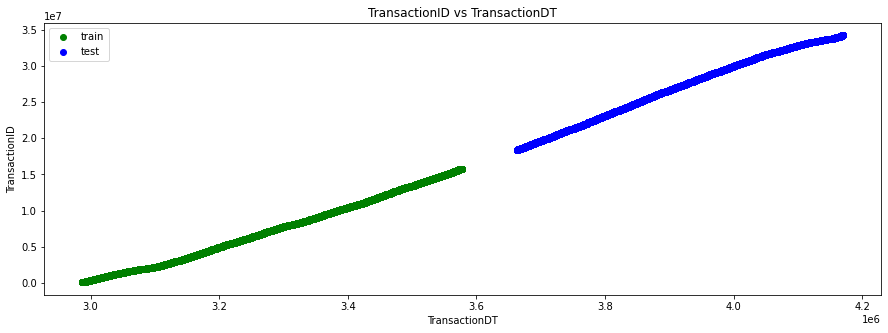

In [7]:
plt.figure(figsize=(15,5))
plt.xlabel('TransactionDT')
plt.ylabel('TransactionID')
plt.title('TransactionID vs TransactionDT')
plt.scatter(df_train['TransactionID'].values,df_train['TransactionDT'].values,c=['g'],label='train')
plt.scatter(df_test['TransactionID'].values,df_test['TransactionDT'].values,c=['b'],label='test')
plt.legend()
plt.show()

### Observations:
1) They removed some part of transaction history from data and seperated them train and test.
2) Credit card transactions of test dataset are future unseen data for our model,we have to consider the effects of covariance shift in test data while modelling.

### Target variable distribution

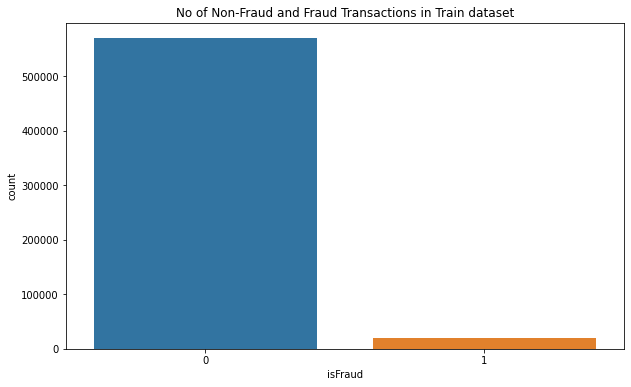

0    569877
1     20663
Name: isFraud, dtype: int64

In [8]:
plt.figure(figsize=(10,6))
sns.countplot(df_train['isFraud'])
plt.title("No of Non-Fraud and Fraud Transactions in Train dataset")
plt.show()
df_train['isFraud'].value_counts()


### Observations:
1) It is an imbalanced dataset of imbalace 1 to 27 i.e for every 1 fraud transaction 27 non-fraud transactions are present.
2) We can expect that in real world as no of fraud transactons are very less compared to valid transactions

### TransactionAmt Distribution

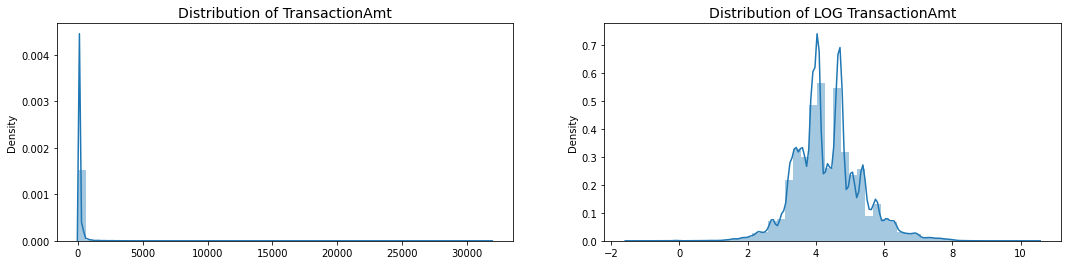

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

sns.distplot(df_train['TransactionAmt'].values, ax=ax[0])
ax[0].set_title('Distribution of TransactionAmt', fontsize=14)
# ax[1].set_xlim([min(time_val), max(time_val)])

sns.distplot(np.log(df_train['TransactionAmt'].values), ax=ax[1])
ax[1].set_title('Distribution of LOG TransactionAmt', fontsize=14)
# ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

plt.show()

### Observations:
1) Distribution of  TransactionAmt is right skewed.
2) Applying  log-transformation on TransactionAmt "pulls in" more extreme values on the right (high values) relative to the median, while values at the far left (low values) tend to get stretched back, further away from the median.

### Box and Violin Plots of Transaction amount

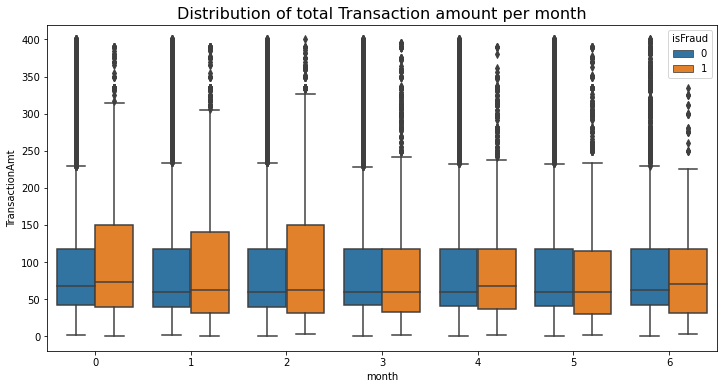

In [10]:
df_month=df_train[['TransactionAmt','month','isFraud']].loc[df_train['TransactionAmt']<400]
plt.figure(figsize=(12,6))
ax = sns.boxplot(x="month", y="TransactionAmt", hue="isFraud", data=df_month)
ax.set_title('Distribution of total Transaction amount per month', fontsize=16)
plt.show()

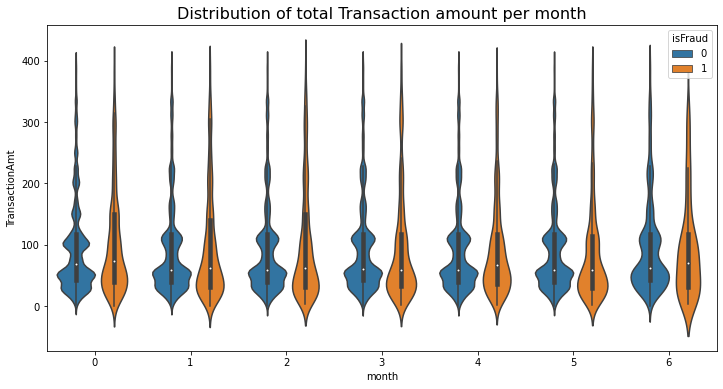

In [11]:
plt.figure(figsize=(12,6))
ax = sns.violinplot(x="month", y="TransactionAmt", hue="isFraud", data=df_month)
ax.set_title('Distribution of total Transaction amount per month', fontsize=16)
plt.show()

### Observations
1) All Fradulent Transactions Amounts are less than 5200 USD,and only 1% of fradulent transaction have Transaction Amount grater than 1000USD.
2) Fraud and non-fraud transaction medians for all months are less than 100 USD.

## EDA For Categorical Features

### ProductCD

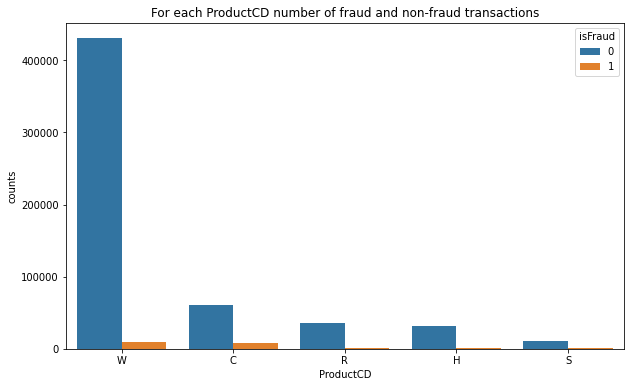

In [12]:
df_productCD=df_train.groupby('isFraud')['ProductCD'].value_counts().rename('counts').reset_index()
plt.figure(figsize=(10,6))
plt.title("For each ProductCD number of fraud and non-fraud transactions")
sns.barplot(x="ProductCD", y="counts", hue="isFraud", data=df_productCD)
plt.show()

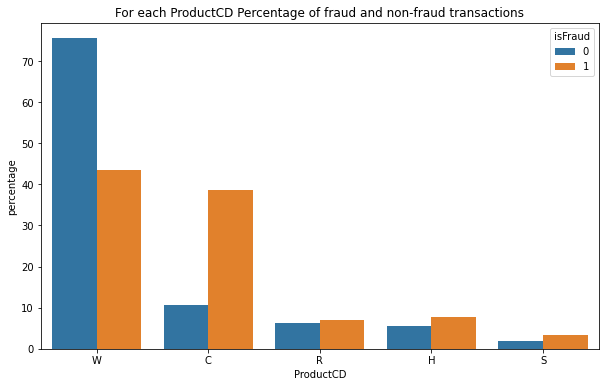

In [13]:
df_productCD=df_train.groupby('isFraud')['ProductCD'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
plt.figure(figsize=(10,6))
plt.title("For each ProductCD Percentage of fraud and non-fraud transactions")
sns.barplot(x="ProductCD", y="percentage", hue="isFraud", data=df_productCD)
plt.show()

### Observations:
1) Heighest Percentage of fraud transactions (43%) and non-fraud transaction(75%) done for 'W' product category.
2) Produc Category 'C' has heighest ratio(3.8) of percentage of fraud to non fraud transactions.

### Card1

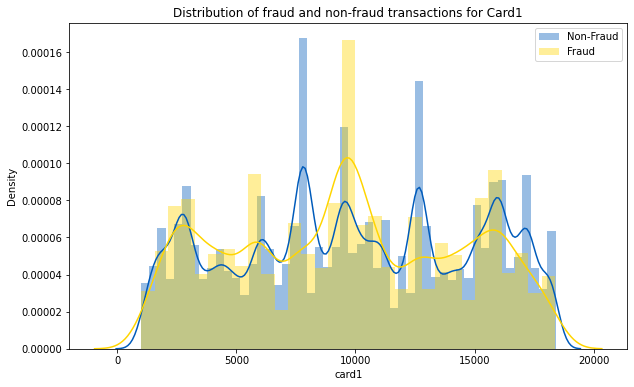

In [14]:
df_temp1=df_train[["TransactionID",'isFraud','card1','card2','card3','card4','card5','card6']]
plt.figure(figsize=(10,6))
sns.distplot(df_temp1[(df_temp1['isFraud']==0)]['card1'], color="#005BBB",label='Non-Fraud')
sns.distplot(df_temp1[(df_temp1['isFraud']==1)]['card1'], color="#FFD500",label='Fraud')
plt.title("Distribution of fraud and non-fraud transactions for Card1")
plt.legend()
plt.show()

### Observations:
1) Distribution of card1 is not skewed and card1 has zero null values.
2) Card1 is used as a unique identification for each creditcard which will be used to perform aggregations.

### Card3

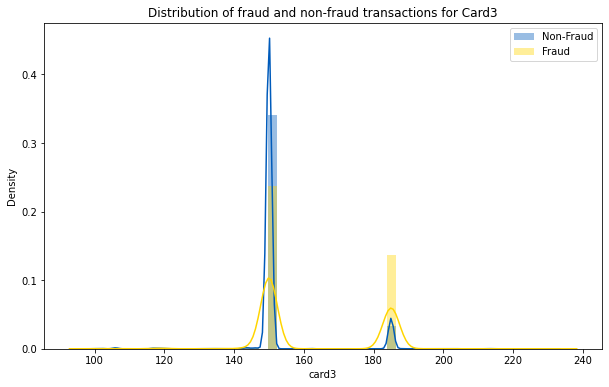

In [15]:
plt.figure(figsize=(10,6))
sns.distplot(df_temp1[(df_temp1['isFraud']==0)]['card3'], color="#005BBB",label='Non-Fraud')
sns.distplot(df_temp1[(df_temp1['isFraud']==1)]['card3'], color="#FFD500",label='Fraud')
plt.title("Distribution of fraud and non-fraud transactions for Card3")
plt.legend()
plt.show()

### Observations:
1) 90 Percent of Card3 number are 150 and 8 percent are 185 we can observe the distribution concentrated around these numbers.

### Card4

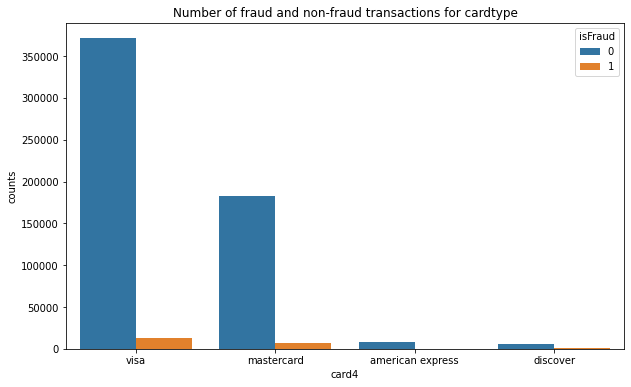

In [16]:
df_cardtype=df_train.groupby('isFraud')['card4'].value_counts().rename('counts').reset_index()
plt.figure(figsize=(10,6))
plt.title("Number of fraud and non-fraud transactions for cardtype")
sns.barplot(x="card4", y="counts", hue="isFraud", data=df_cardtype)
plt.show()

In [17]:
df_card4=df_temp1[['TransactionID','card4','isFraud']].groupby(['card4','isFraud']).count().reset_index()
df_card4_fraud=df_card4[['TransactionID','card4','isFraud']].loc[df_card4['isFraud']==1]
df_card4_non_fraud=df_card4[['TransactionID','card4','isFraud']].loc[df_card4['isFraud']==0]
df_card4_fraud['Percentage_fraud']=df_card4_fraud['TransactionID']*100/df_card4_fraud['TransactionID'].sum()
df_card4_non_fraud['Percentage_nonfraud']=df_card4_non_fraud['TransactionID']*100/df_card4_non_fraud['TransactionID'].sum()

In [18]:
df_temp_test=pd.DataFrame(df_test['card4'].unique()[:-1],df_test['card4'].value_counts(normalize=True).mul(100).values).reset_index().rename(columns={'index':'percentage',0:'card'})

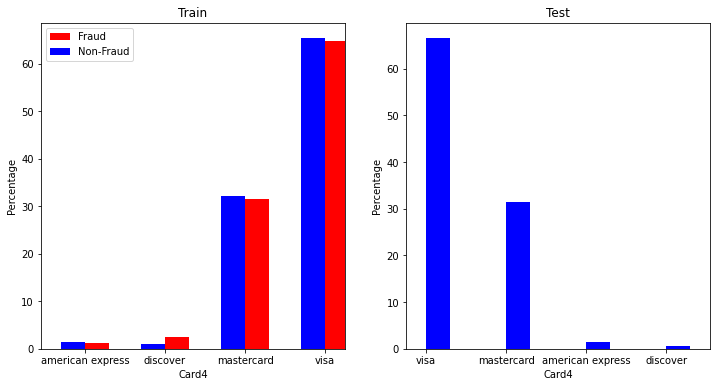

In [19]:
fig = plt.figure(figsize=(12,6)) # Create matplotlib figure

ax = fig.add_subplot(121) # Create matplotlib axes
ax1= fig.add_subplot(122)

width = 0.3
df_card4_fraud.Percentage_fraud.plot(kind='bar', color='red', ax=ax, width=width, position=0,label='Fraud')
df_card4_non_fraud.Percentage_nonfraud.plot(kind='bar', color='blue', ax=ax, width=width, position=1,label='Non-Fraud')
ax.set_ylabel('Percentage')
ax.set_xticklabels(df_card4_fraud.card4.values,rotation=0)
ax.set_xlabel('Card4')
ax.legend()
ax.title.set_text('Train')

# plot for test 

df_temp_test.percentage.plot(kind='bar', color='blue', ax=ax1, width=width, position=0)
ax1.set_ylabel('Percentage')
ax1.set_xticklabels(df_temp_test.card.values,rotation=0)
ax1.set_xlabel('Card4')
plt.title('Test')
plt.show()


### Observations:
1) Both test and train datasets have simillar card type.
2) Visa card type is the majority class in both data sets followed by mastercard

### Card6

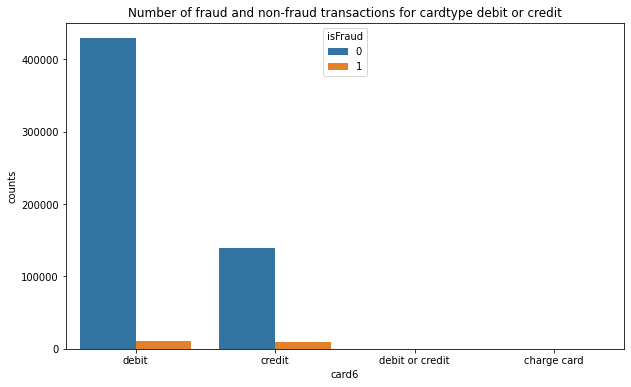

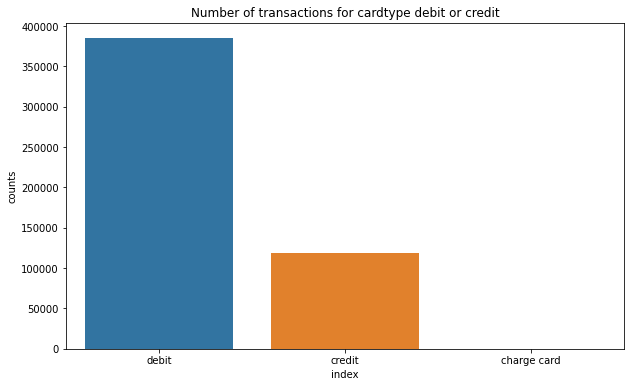

In [20]:
df_cardtype=df_train.groupby('isFraud')['card6'].value_counts().rename('counts').reset_index()
plt.figure(figsize=(10,6))
plt.title("Number of fraud and non-fraud transactions for cardtype debit or credit")
sns.barplot(x="card6", y="counts", hue="isFraud", data=df_cardtype)
plt.show()
df_cardtype=df_test['card6'].value_counts().rename('counts').reset_index()
plt.figure(figsize=(10,6))
plt.title("Number of transactions for cardtype debit or credit")
sns.barplot(x="index", y="counts", data=df_cardtype)
plt.show()


### Observations:
1) There is no credit or debit card type in test data.
2) To ensure no data leakage while converting card6 categorical feature to one hot encoding we use unknown.

### D1 to D15 The D Columns are "time deltas" from some point in the past 

In [23]:
df_d=df_train[['TransactionID','TransactionDT','D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11','D12','D13','D14','D15','isFraud']]

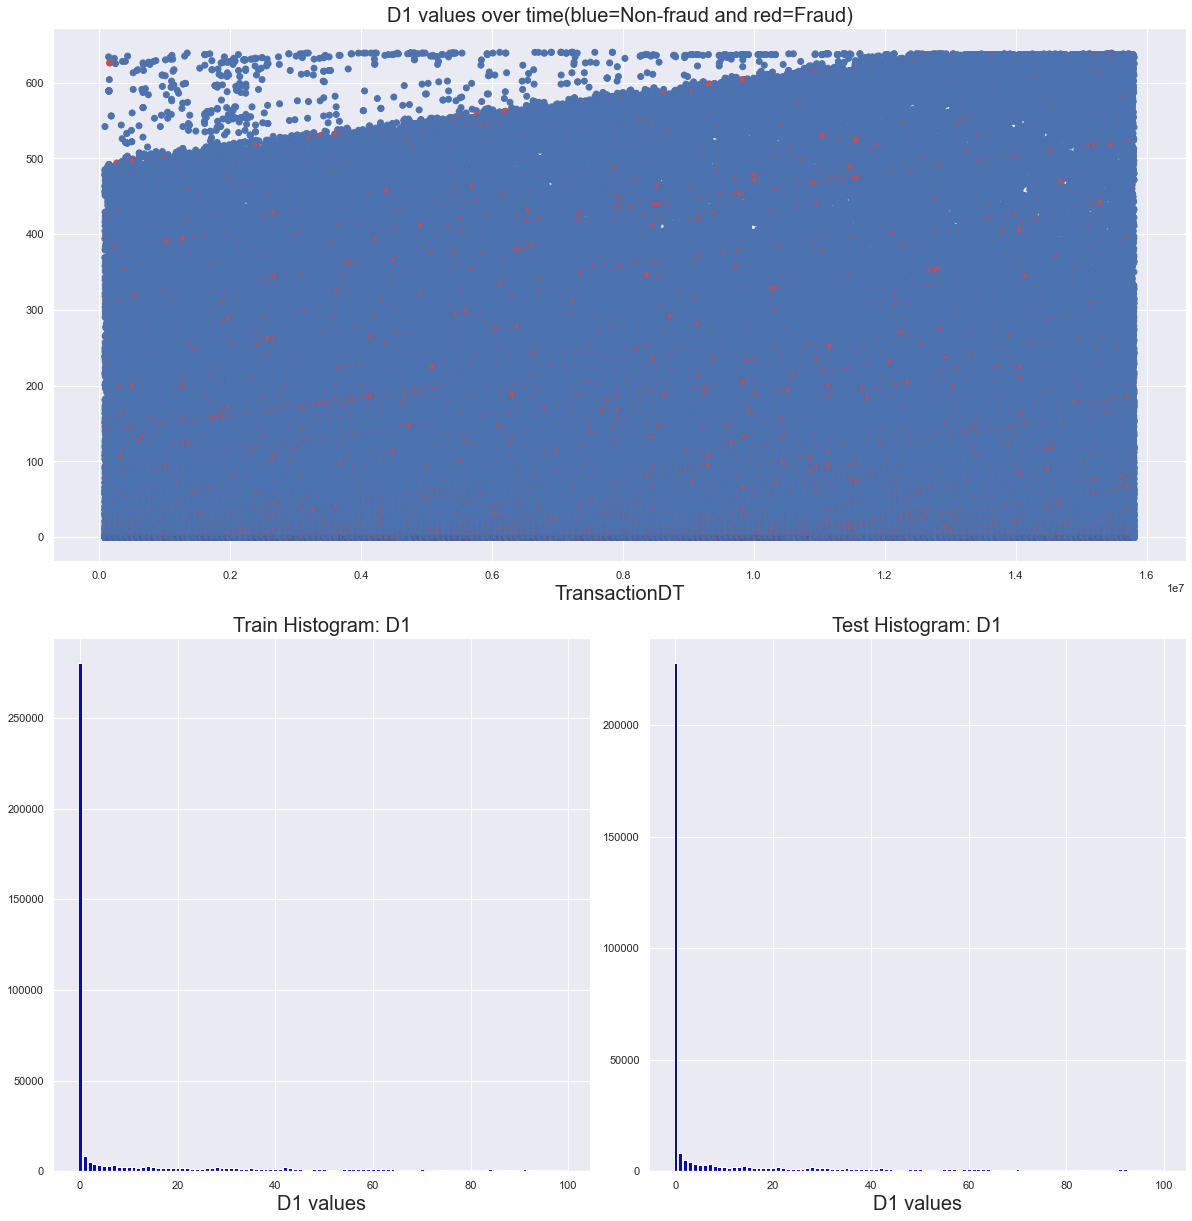

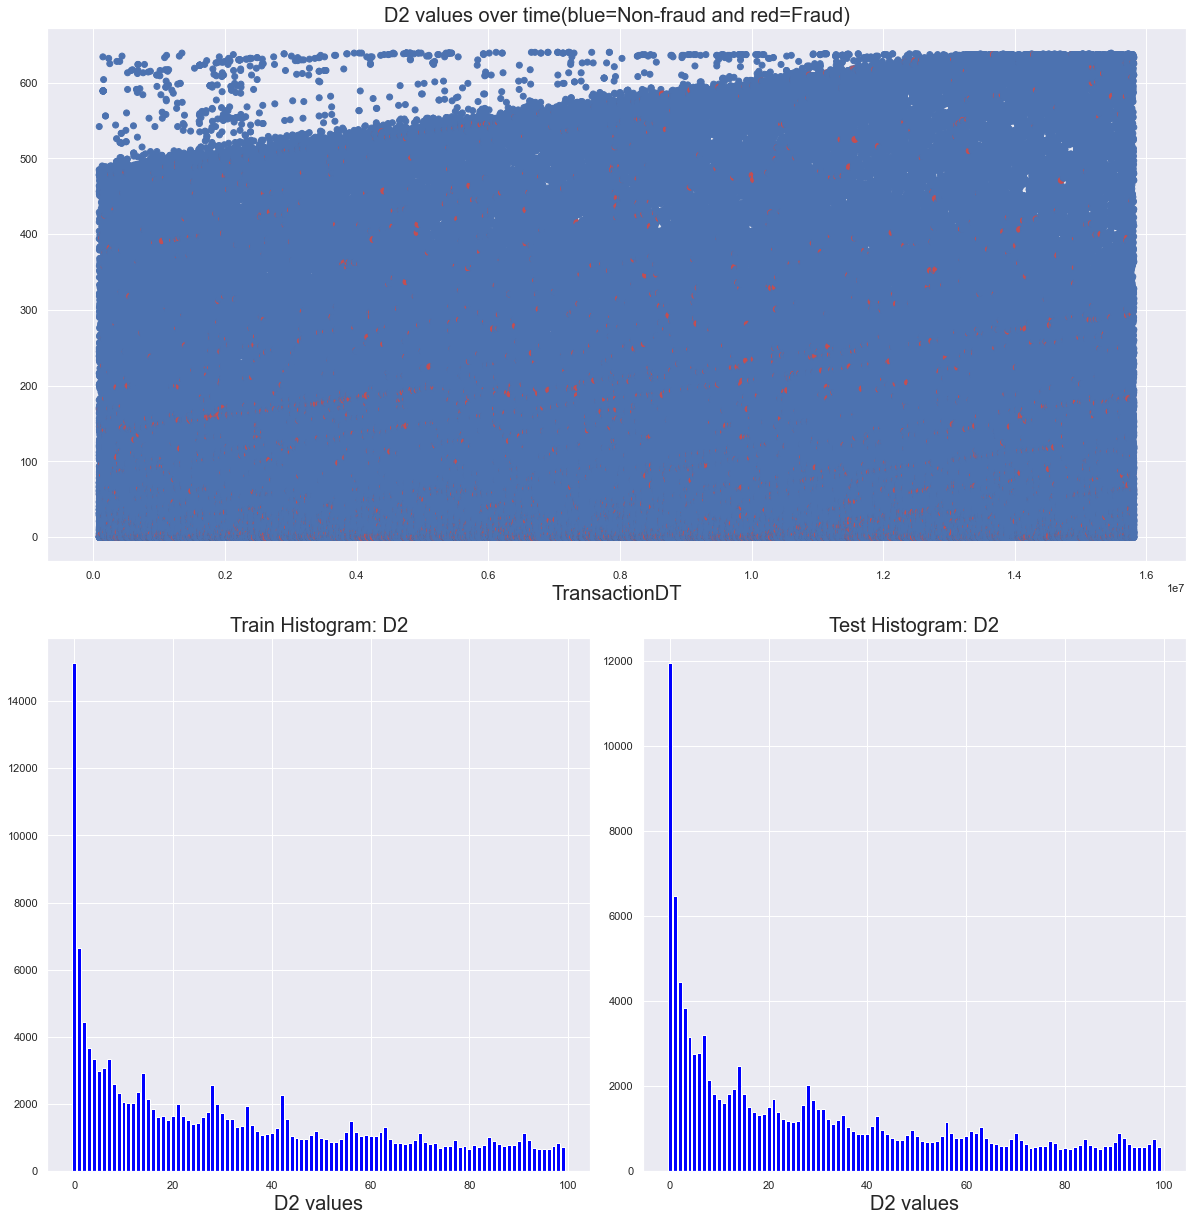

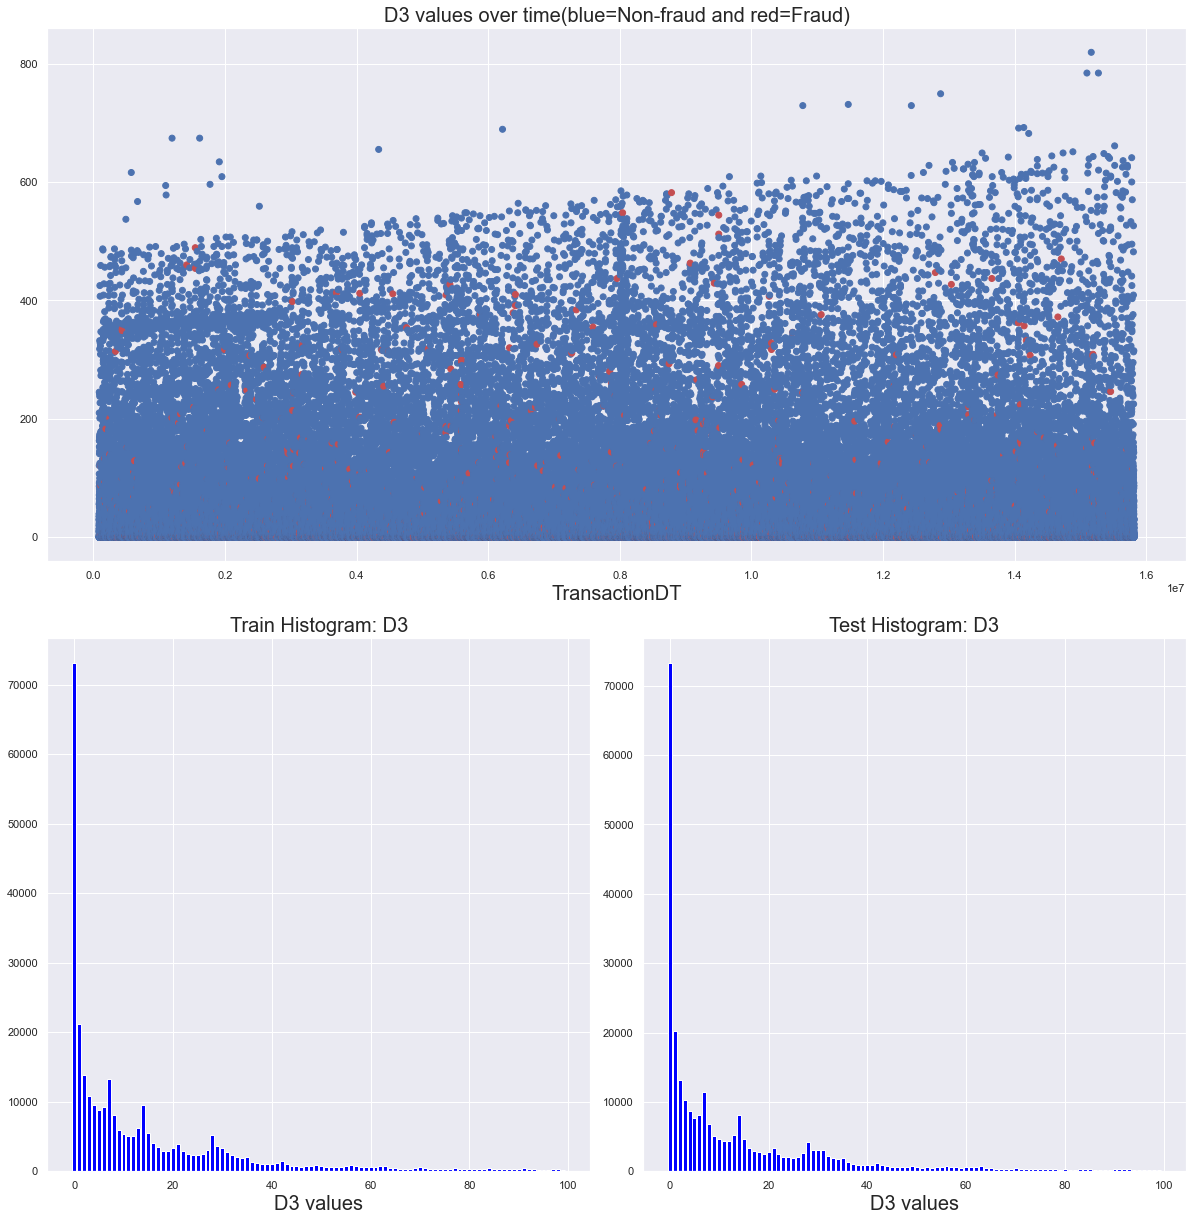

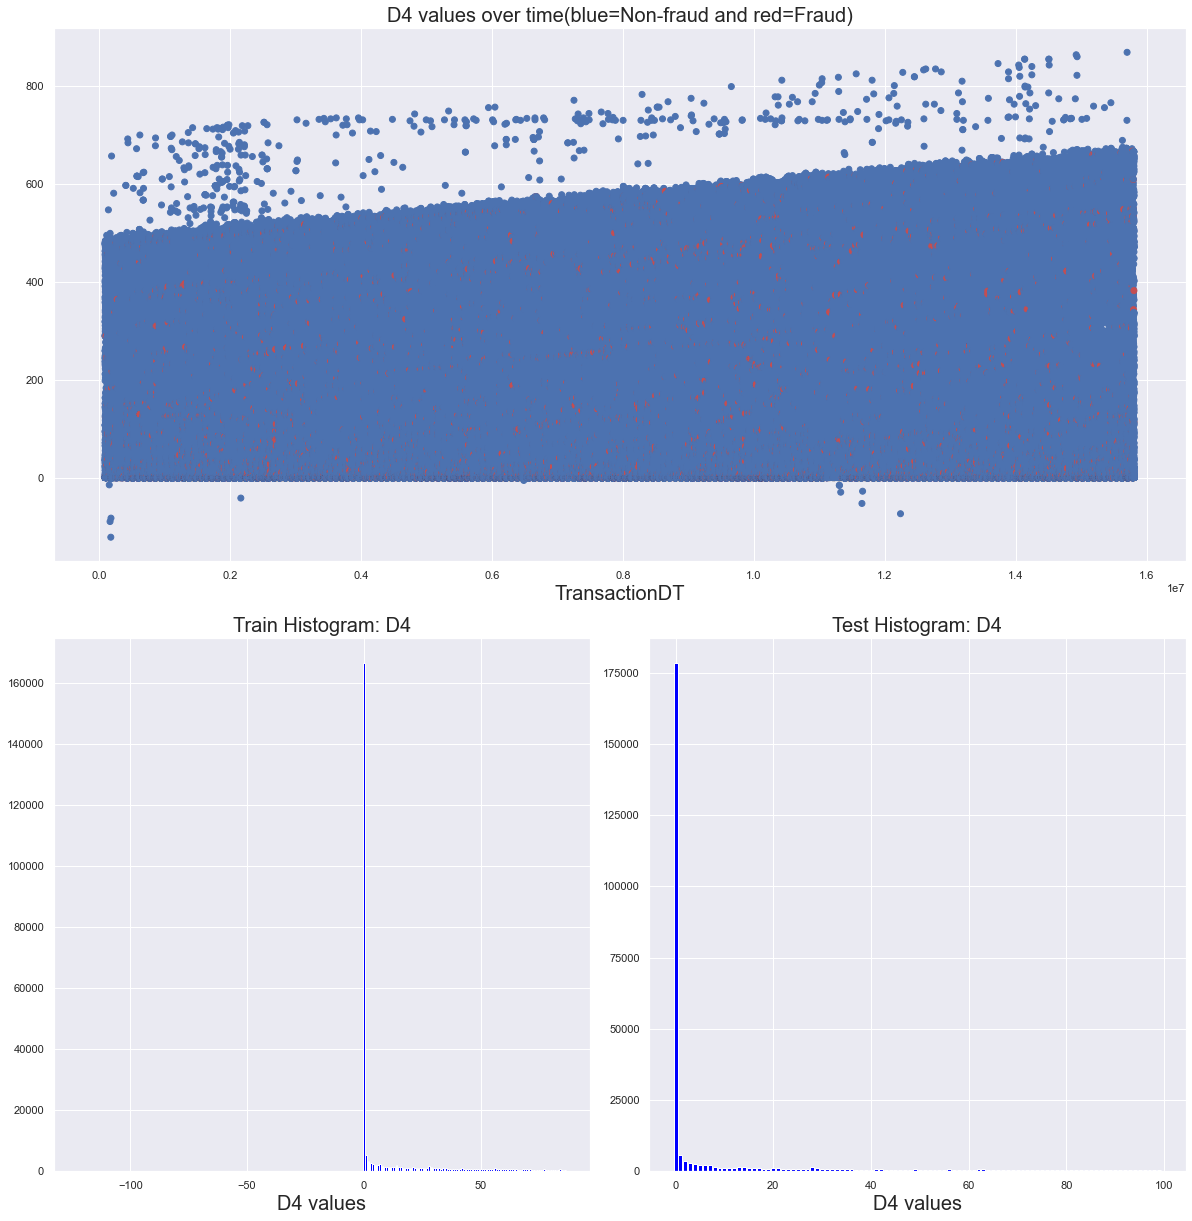

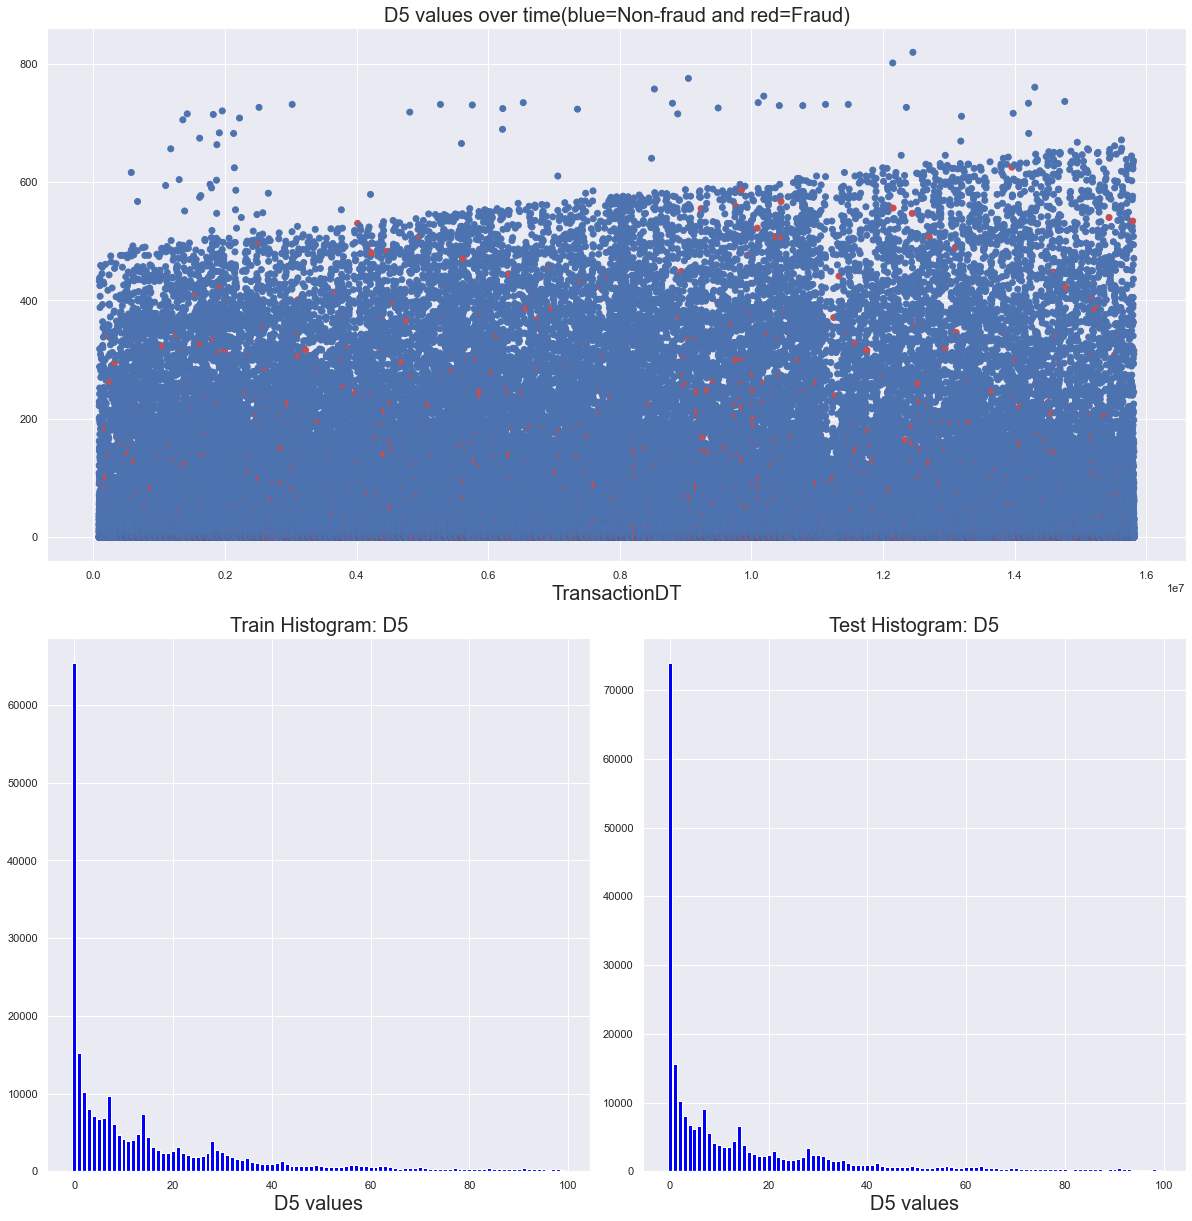

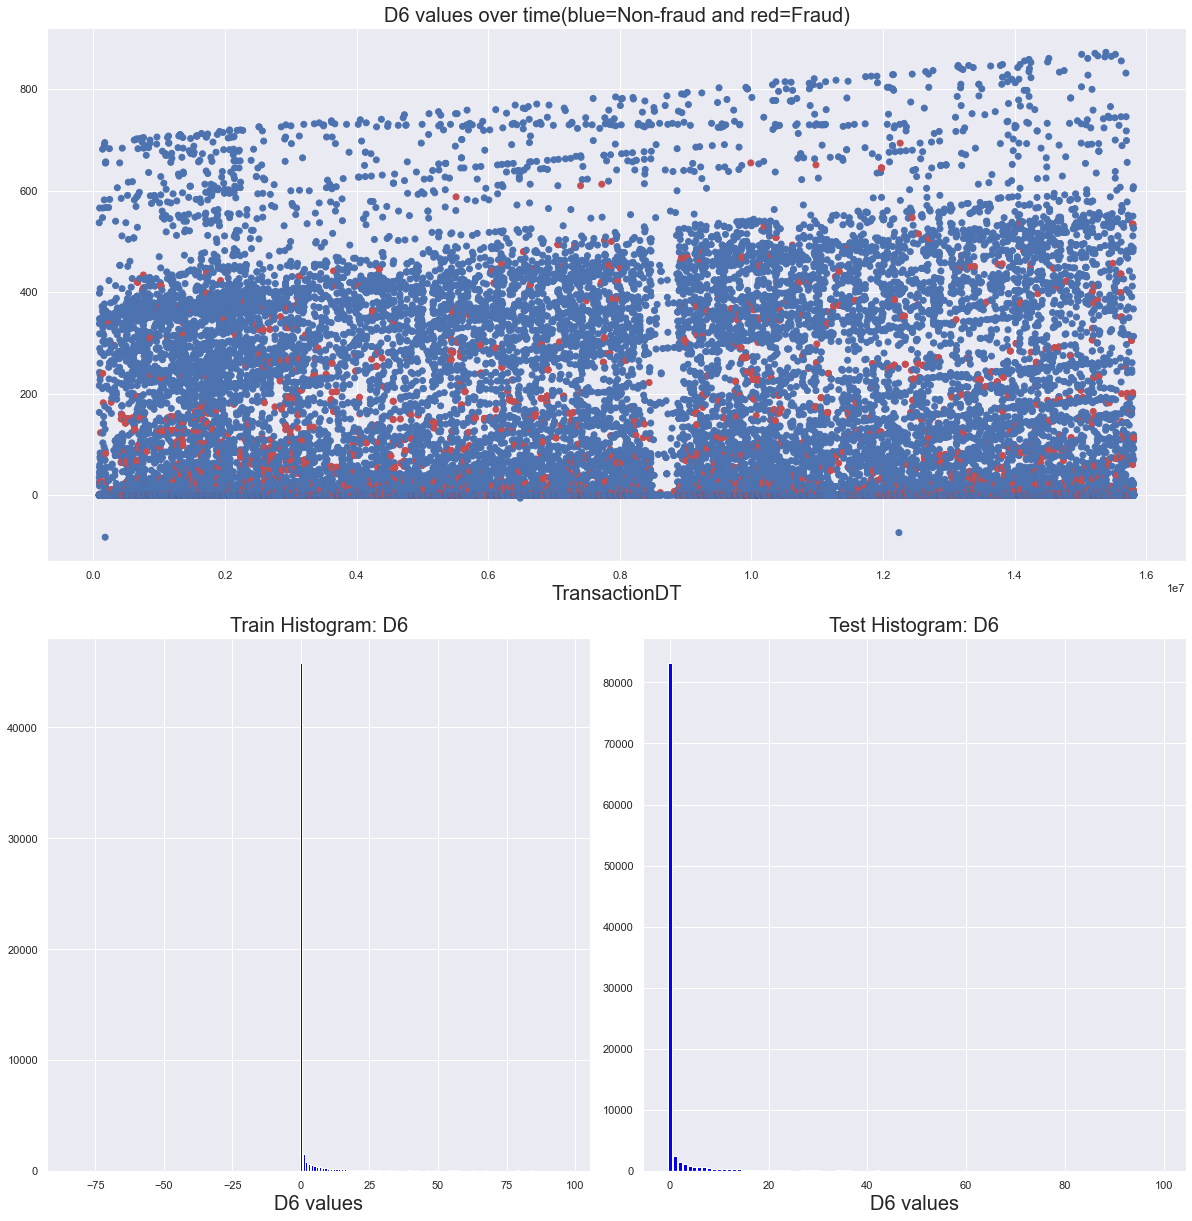

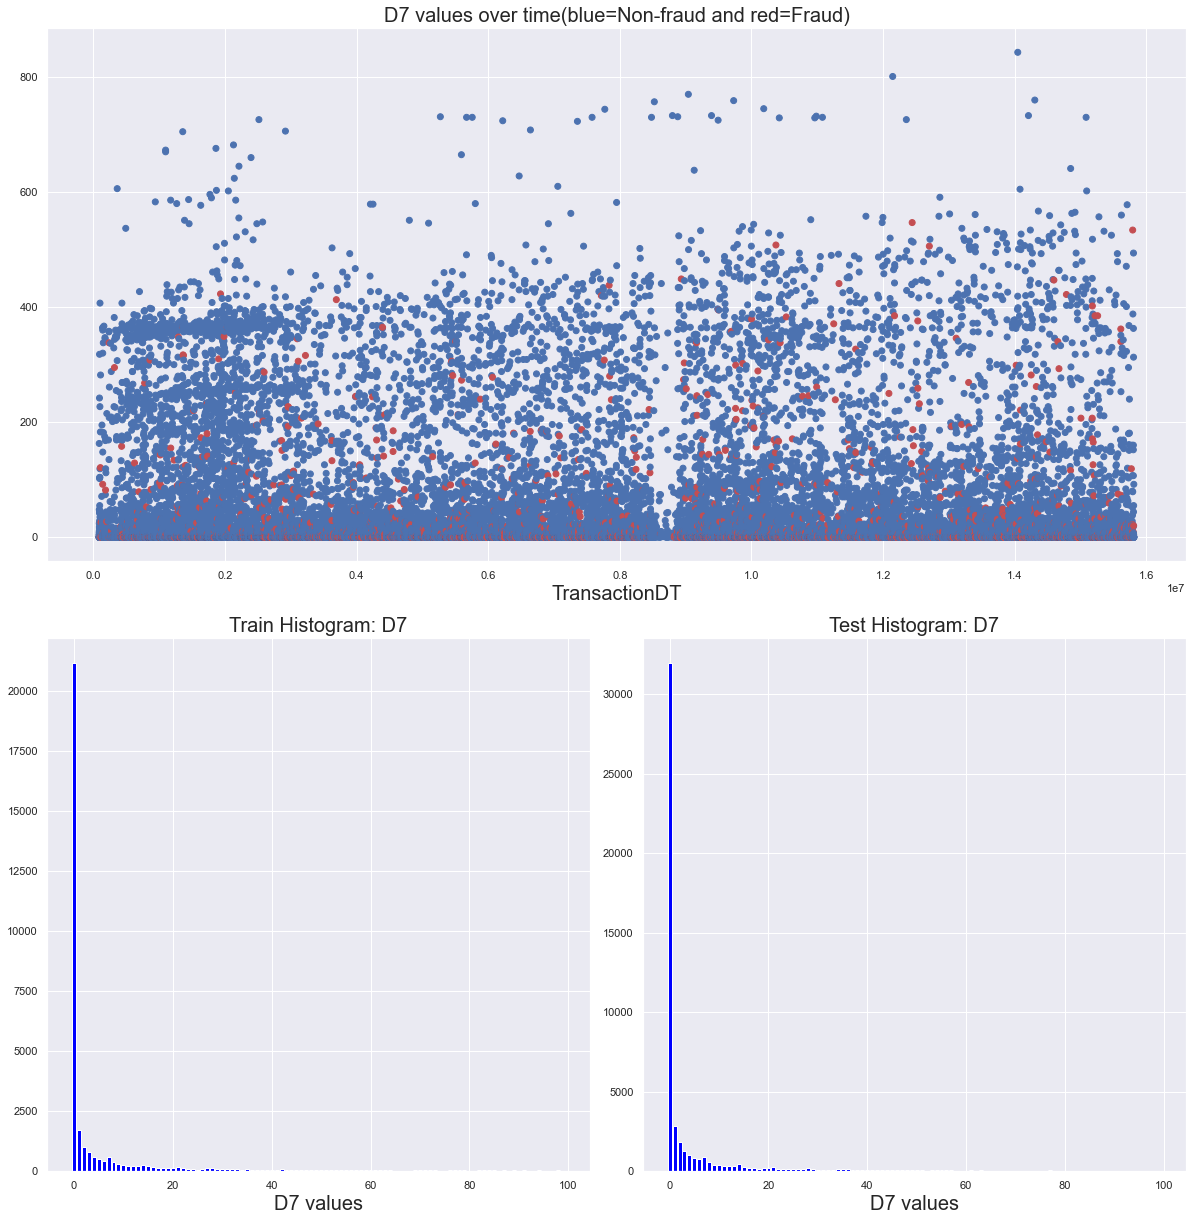

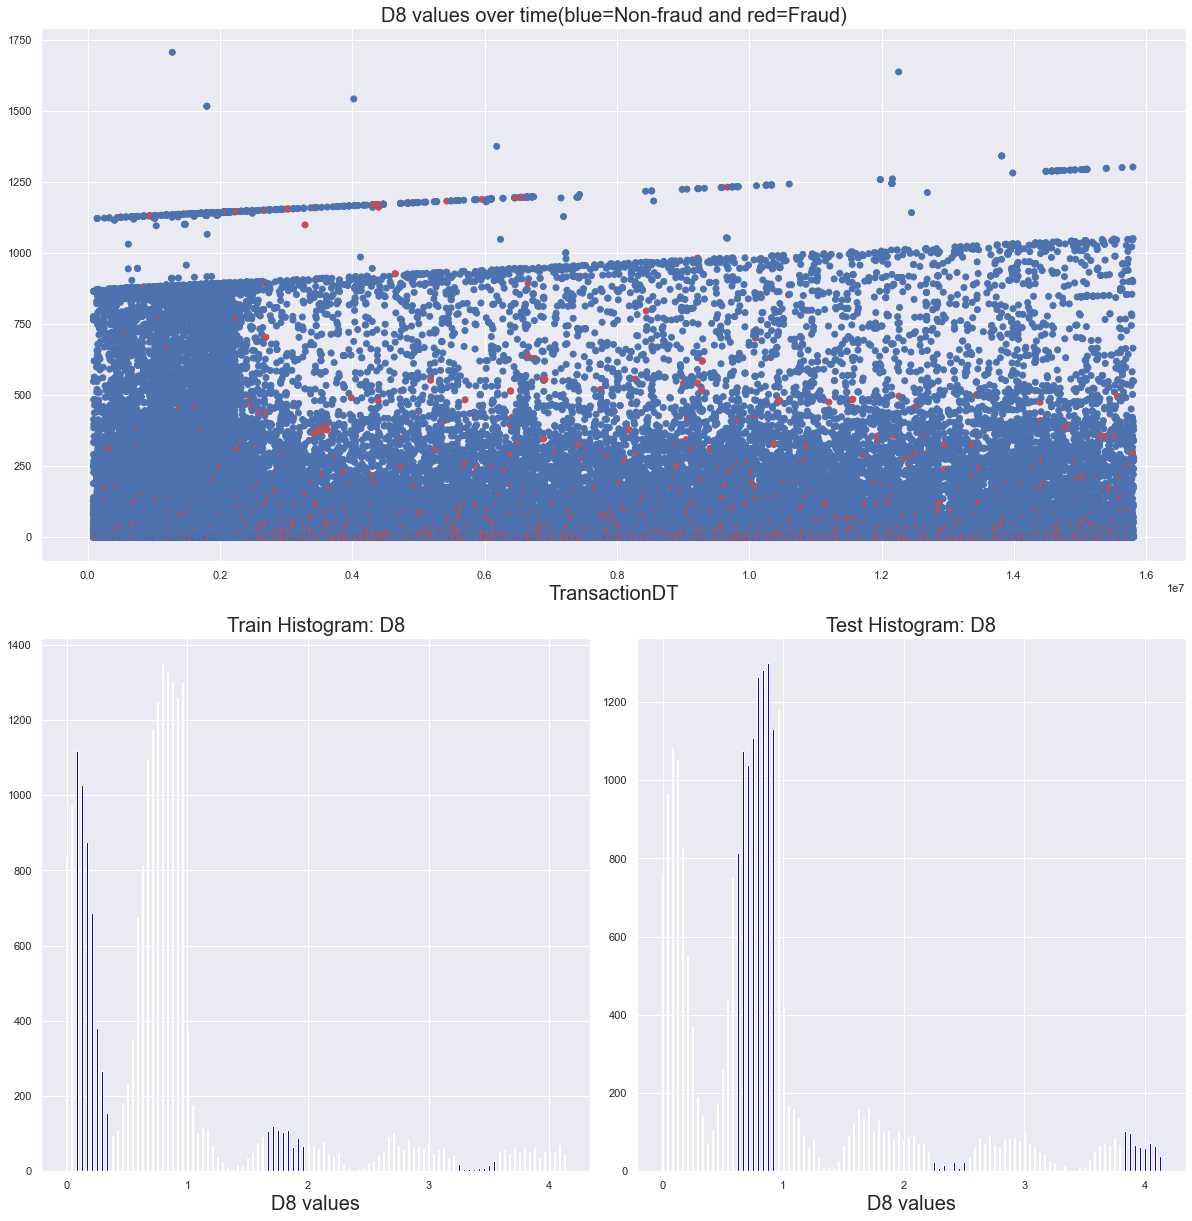

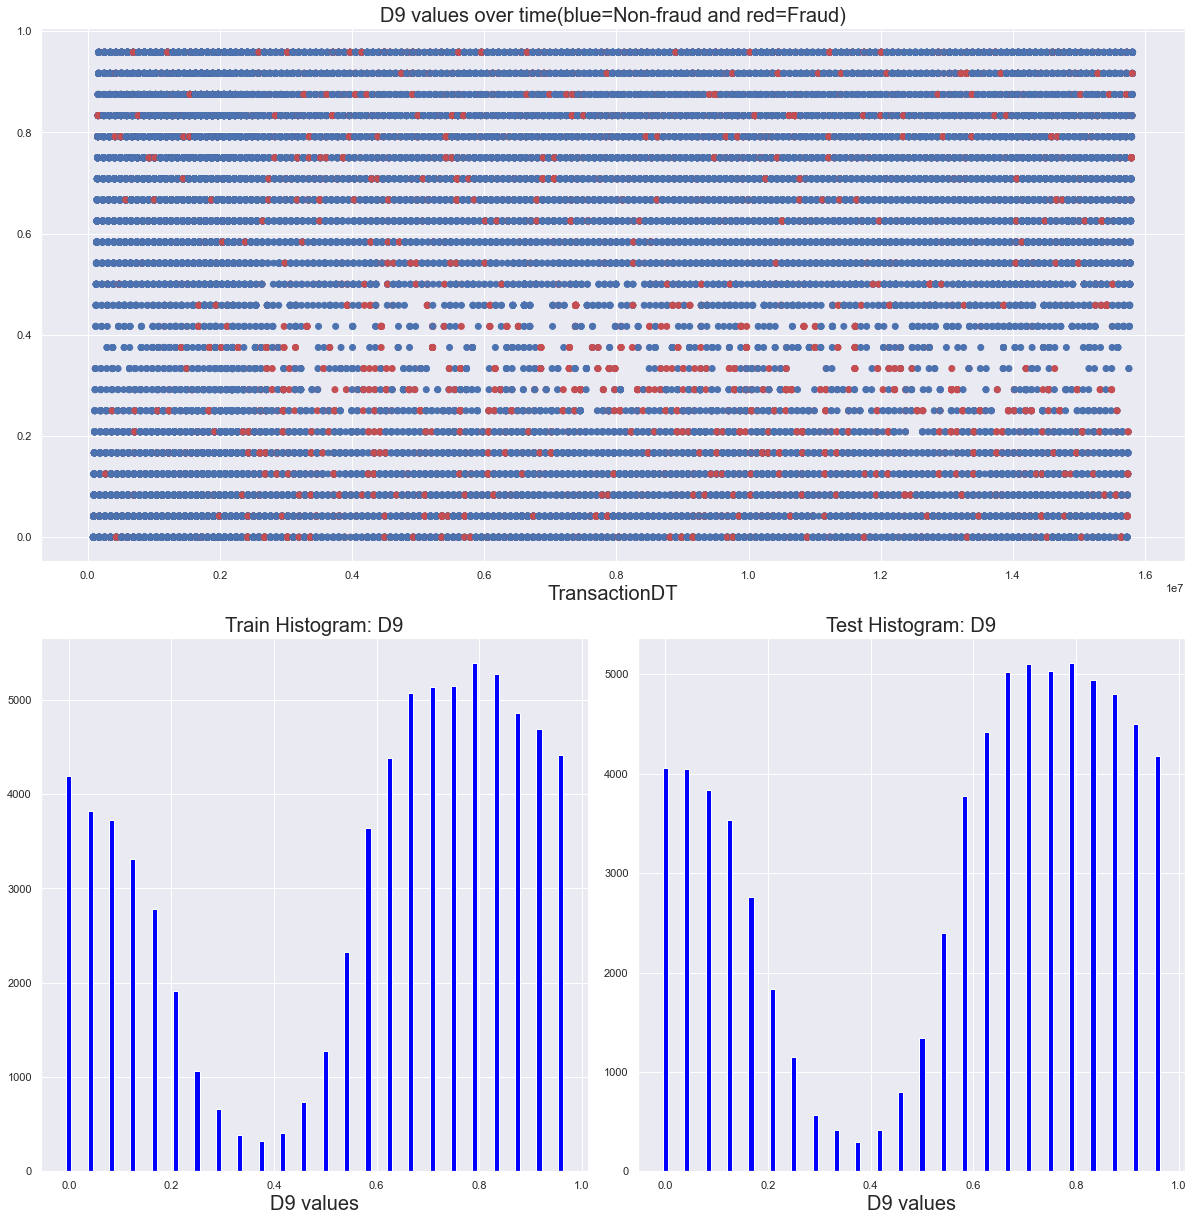

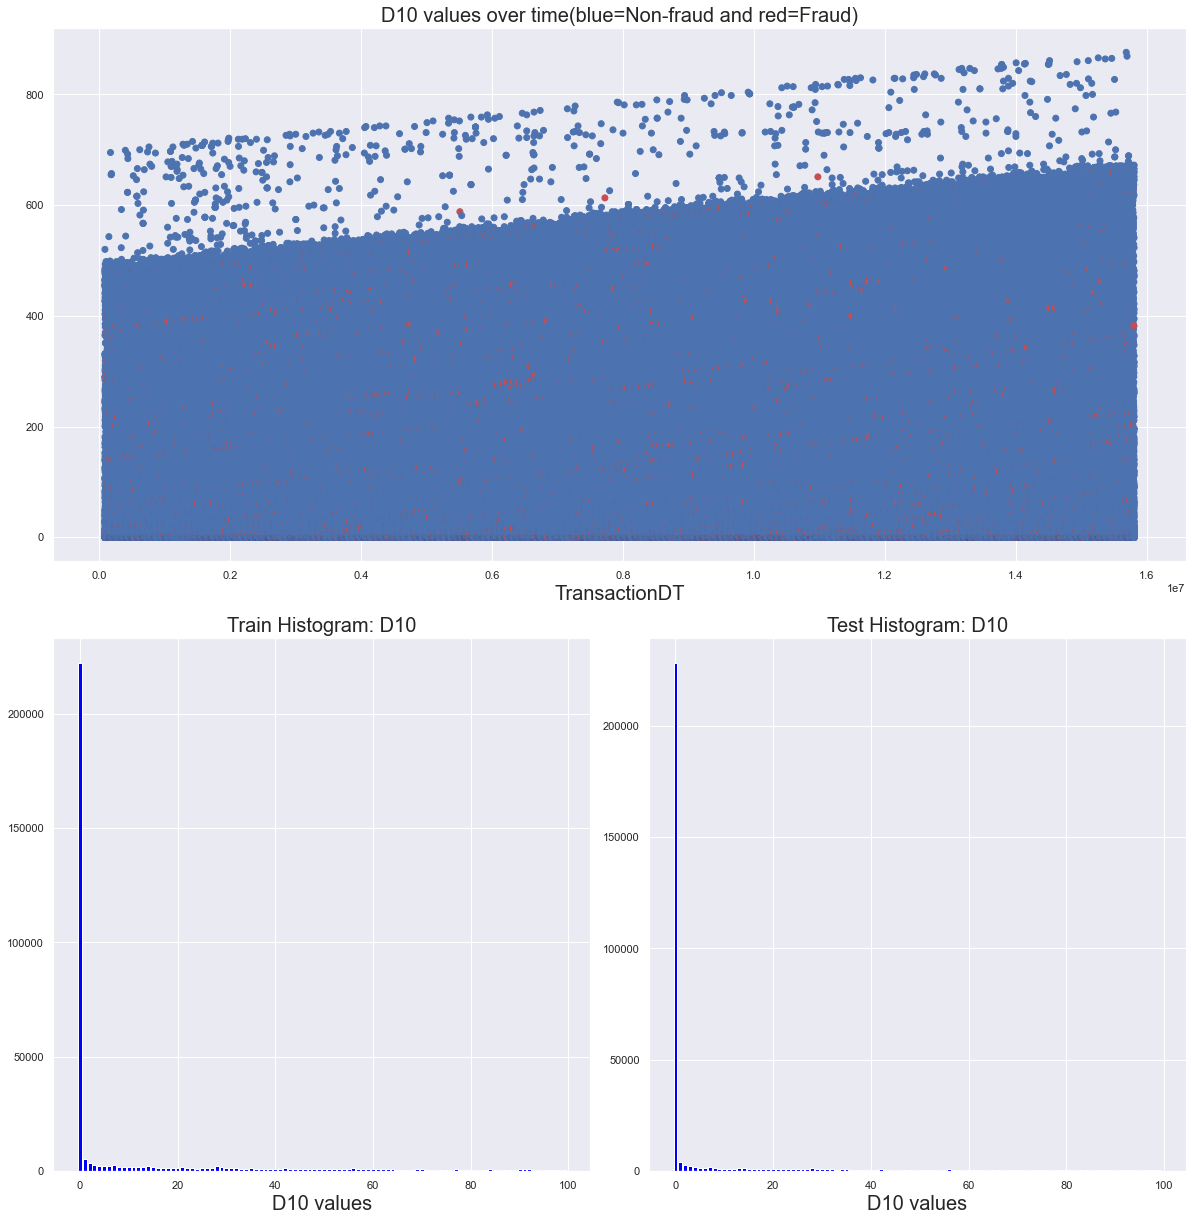

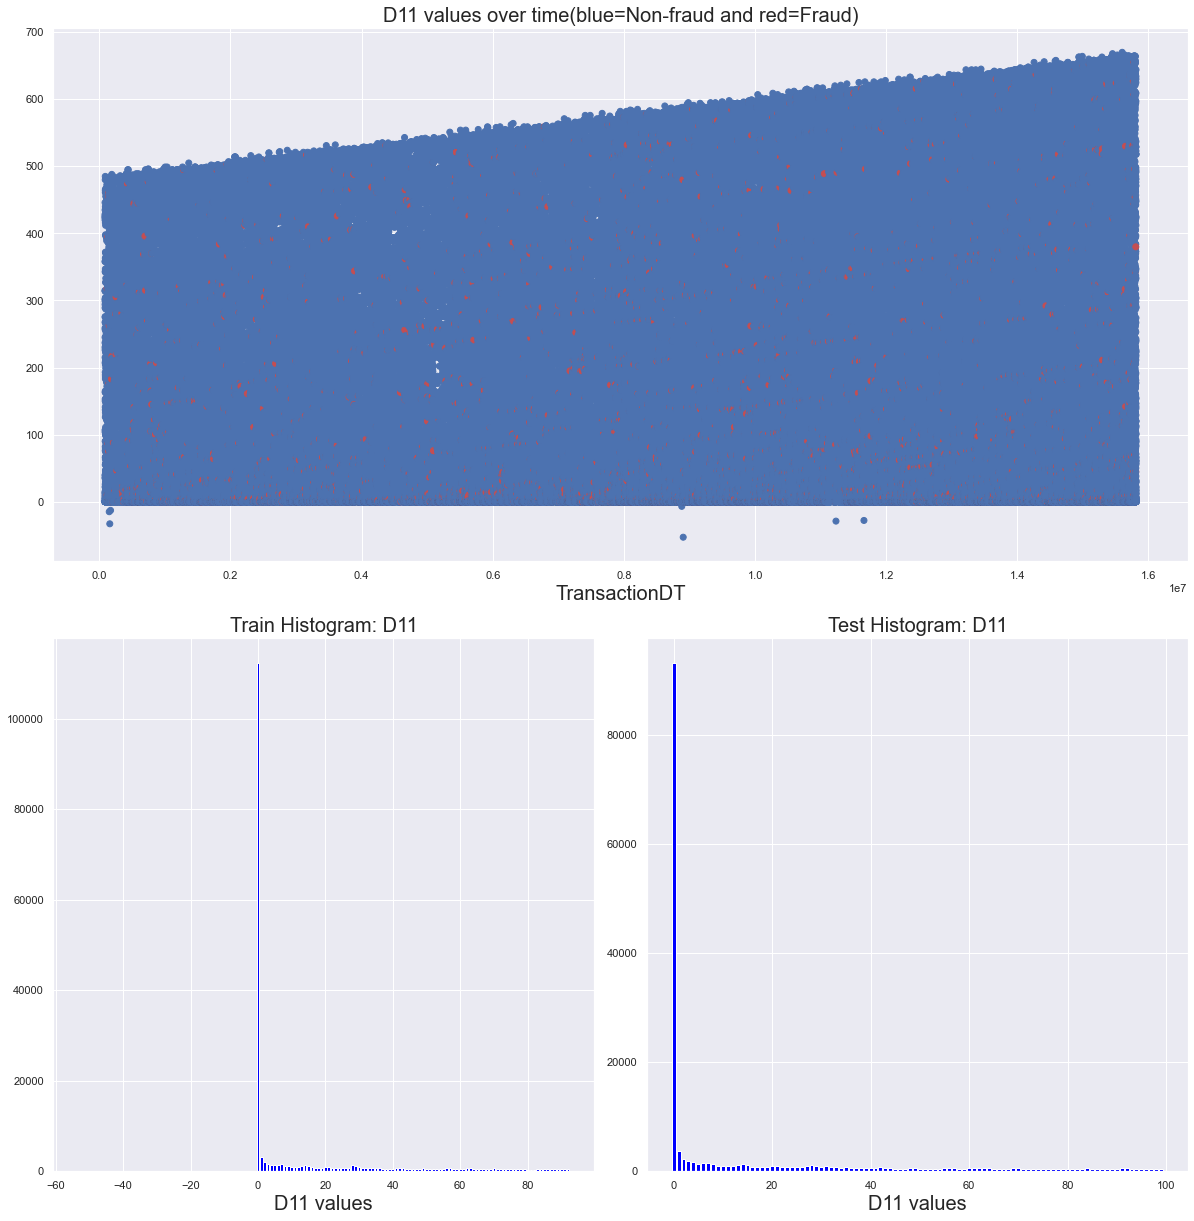

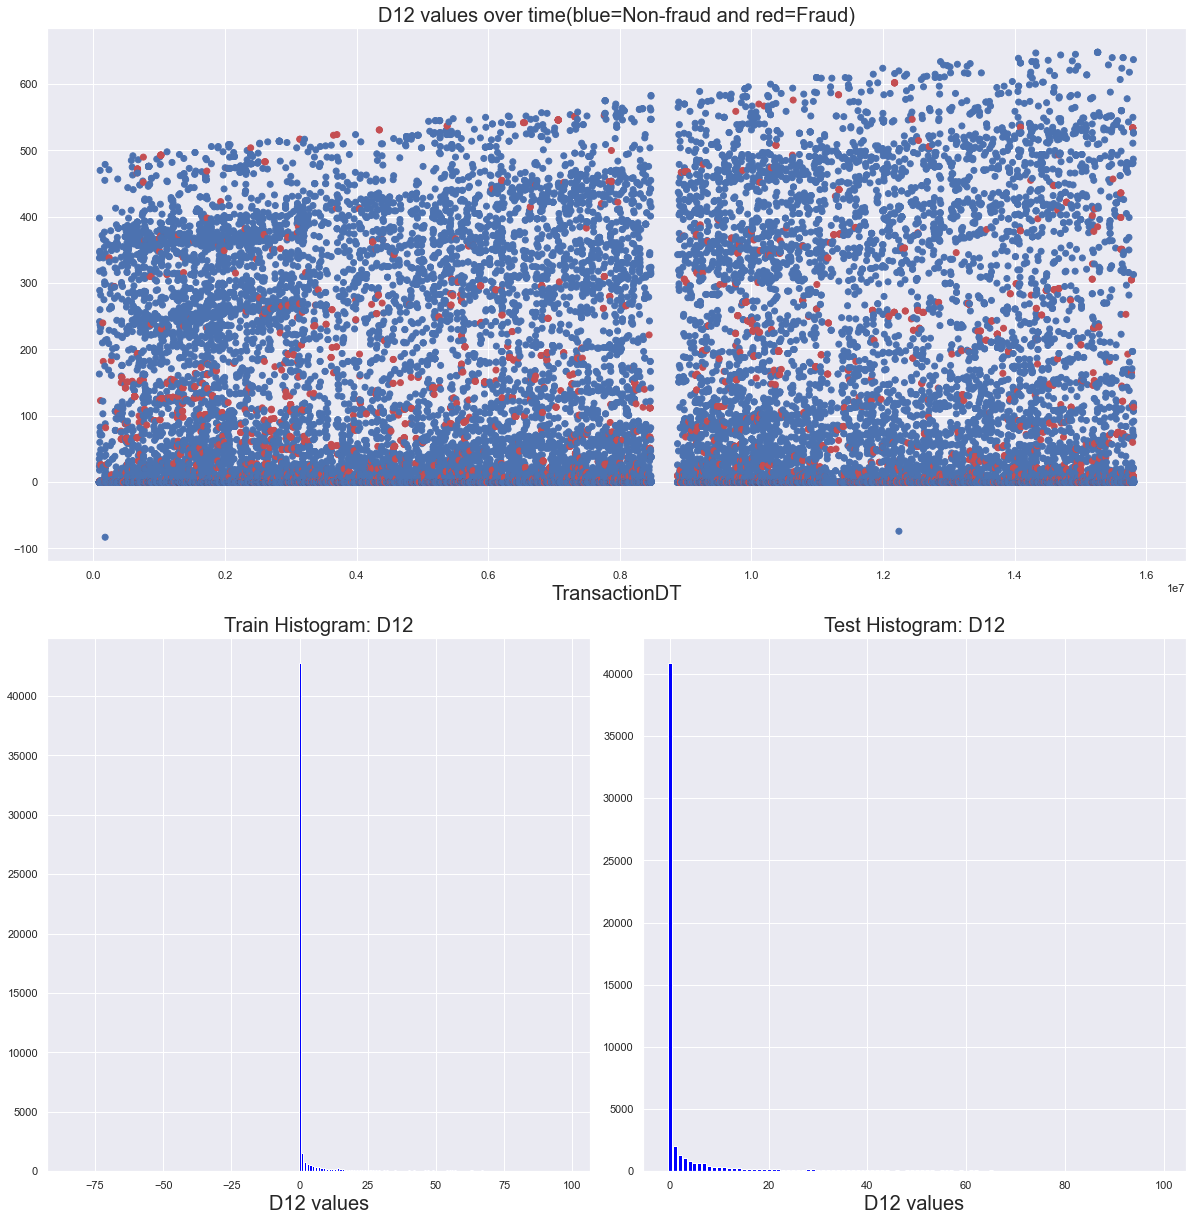

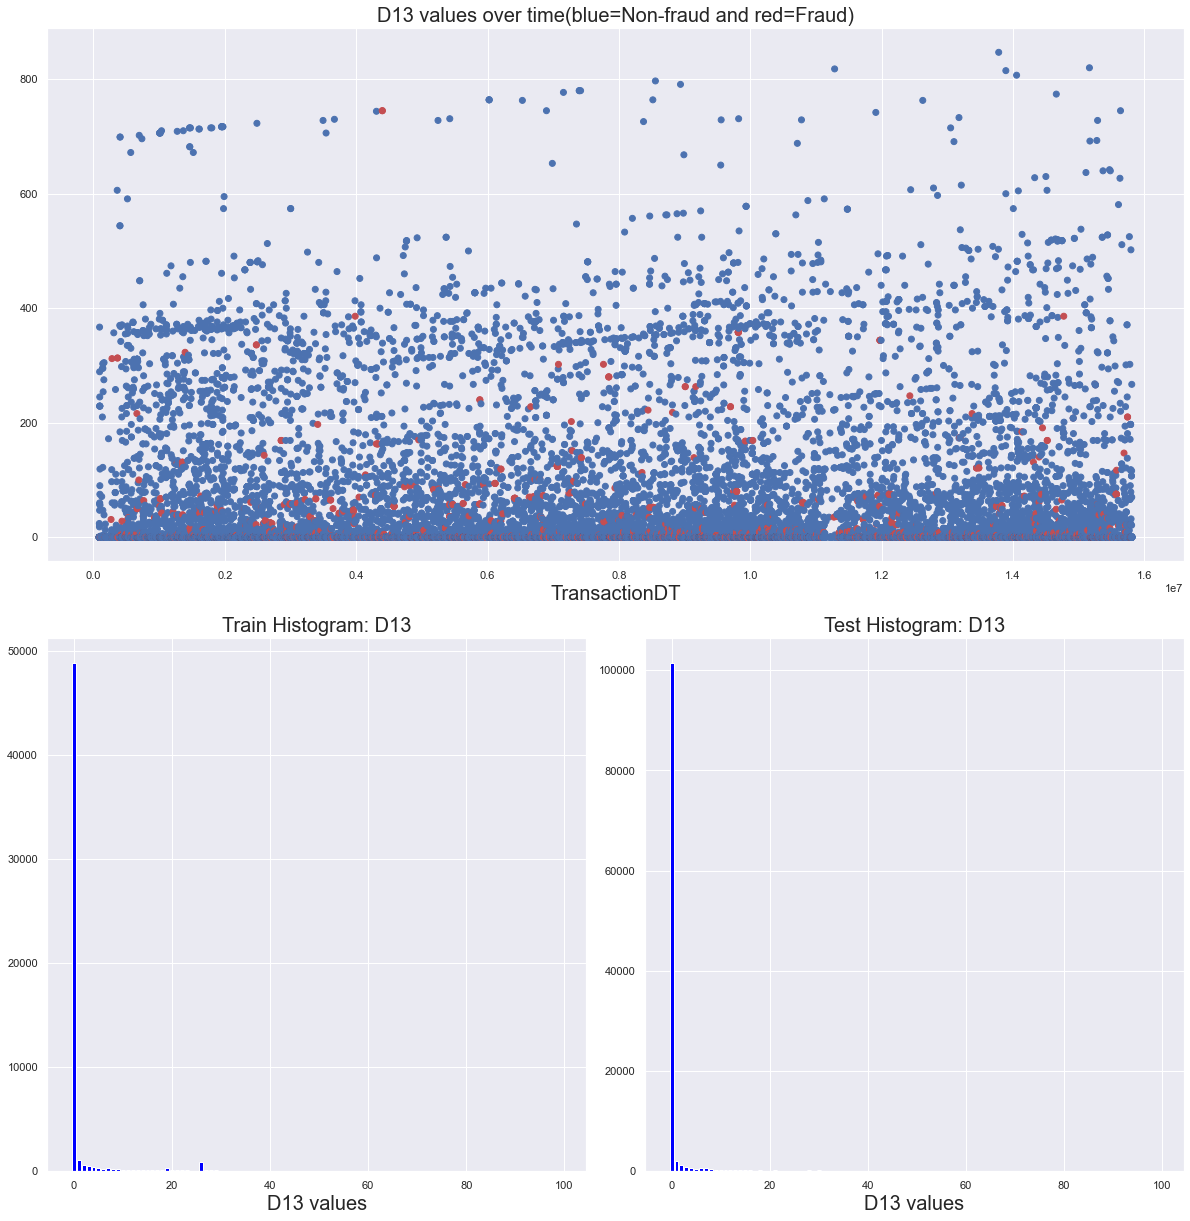

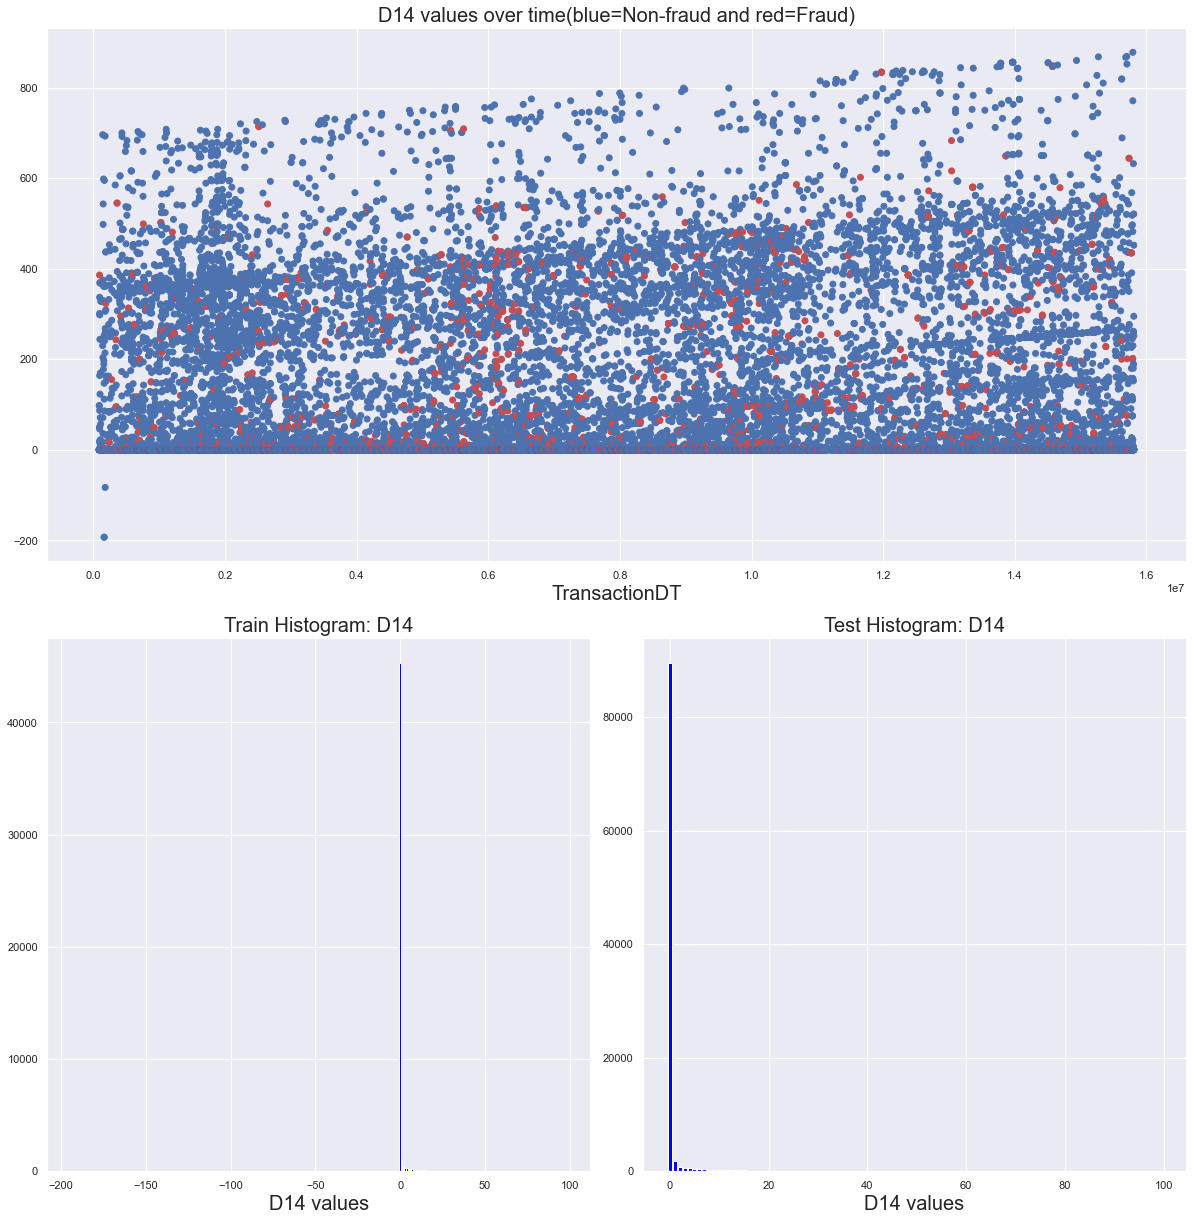

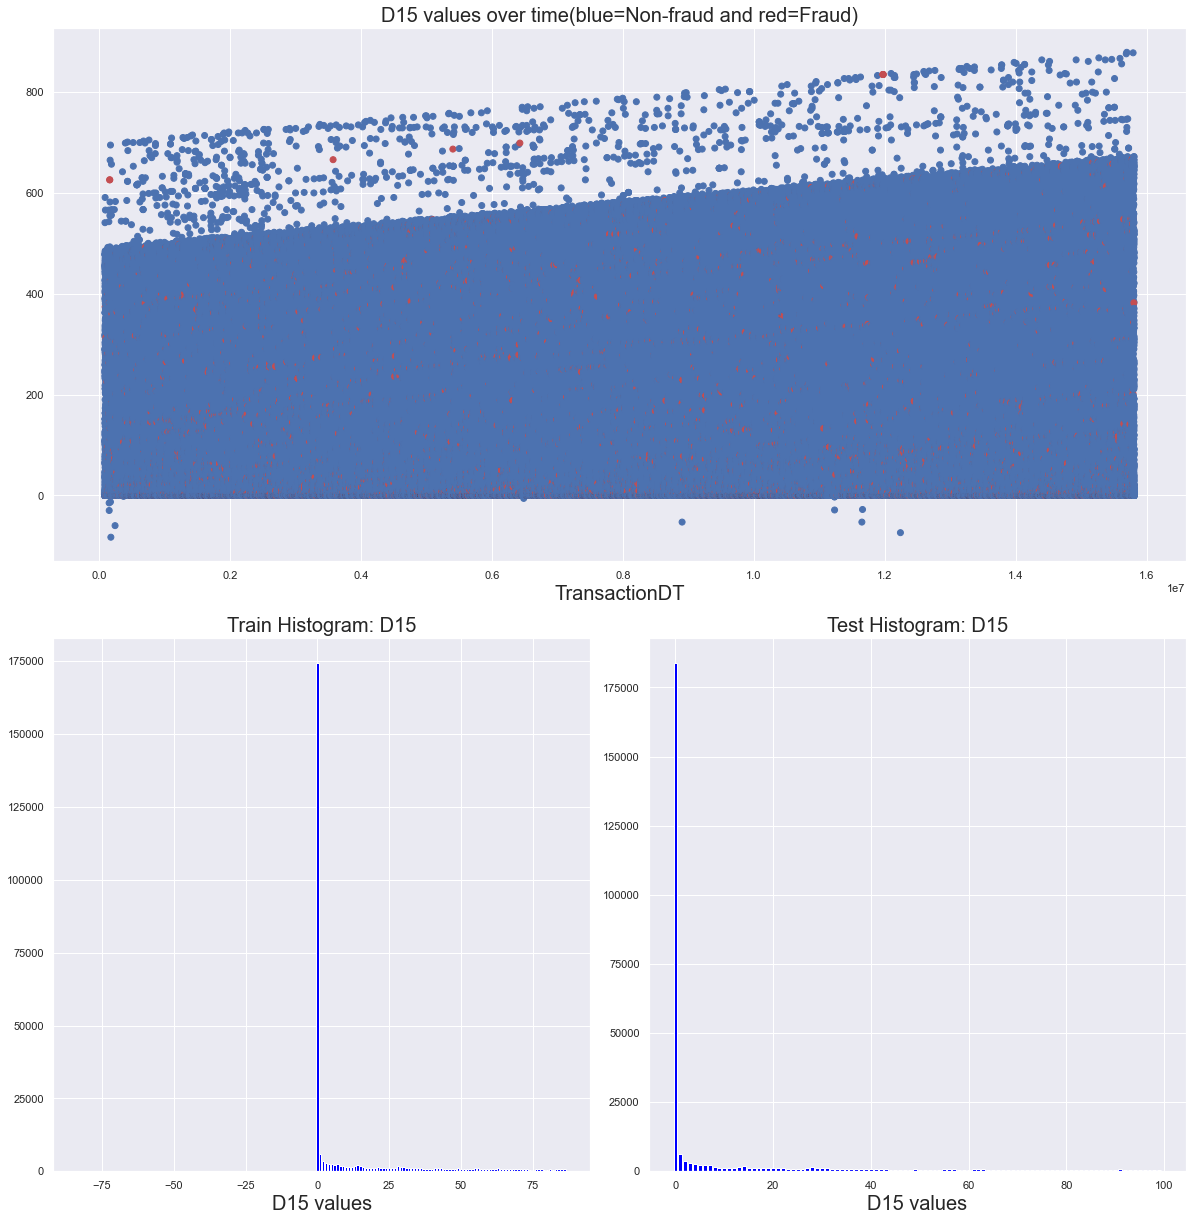

In [39]:
'''plot.subplot2grid is used to create a grid of 3 plots in two rows with 
   plot1 we acces the grid and plot one scatter plot between TransactionDT and D columns
   plot2,plot3 for train and test histograms for each D column and 
   we are considering only 100 points to plot D histogram is highly right skewed'''

for col in df_d.columns:
    if col!='isFraud':
        plot1 = plt.subplot2grid((3, 3), (0, 0), colspan=2,rowspan=1)
        plot2 = plt.subplot2grid((3, 3), (1, 0), rowspan=1,colspan=1)
        plot3 = plt.subplot2grid((3, 3), (1, 1), rowspan=1,colspan=1)
        colors = ListedColormap(['b','r'])
        if col!='TransactionID' and col!='TransactionDT':
        # plot TransactionDT vs D columns
            plot1.scatter(df_train['TransactionDT'],df_train[col], c =df_train['isFraud'],cmap=colors)
            plot1.set_xlabel('TransactionDT',fontsize=20)
            plot1.set_title(col+' values over time'+'(blue=Non-fraud and red=Fraud)',fontsize=20)
        
            if col=='D8' or col=='D9':
                # plot train histogram of D columns
                df_d1=df_train[['TransactionID',col]].groupby(col).size().reset_index()
                plot2.bar(df_d1[col].values[:100],df_d1[0].values[:100],color='blue',width=0.01)
                plot2.set_xlabel(col+' values',fontsize=20)
                plot2.set_title('Train Histogram: '+col,fontsize=20)
                # plot test histogram of D columns
                df_d1=df_test[['TransactionID',col]].groupby(col).size().reset_index()
                plot3.bar(df_d1[col].values[:100],df_d1[0].values[:100],color='blue',width=0.01)
                plot3.set_xlabel(col+' values',fontsize=20)
                plot3.set_title('Test Histogram: '+col,fontsize=20)
            else:
                df_d1=df_train[['TransactionID',col]].groupby(col).size().reset_index()
                plot2.bar(df_d1[col].values[:100],df_d1[0].values[:100],color='blue')
                plot2.set_xlabel(col+' values',fontsize=20)
                plot2.set_title('Train Histogram: '+col,fontsize=20)
                df_d1=df_test[['TransactionID',col]].groupby(col).size().reset_index()
                plot3.bar(df_d1[col].values[:100],df_d1[0].values[:100],color='blue')
                plot3.set_xlabel(col+' values',fontsize=20)
                plot3.set_title('Test Histogram: '+col,fontsize=20)
            plt.tight_layout()
            plt.show()
    

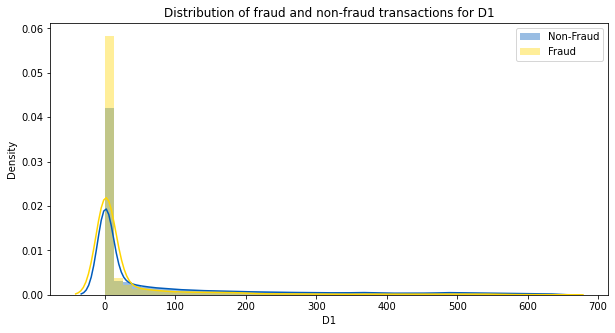

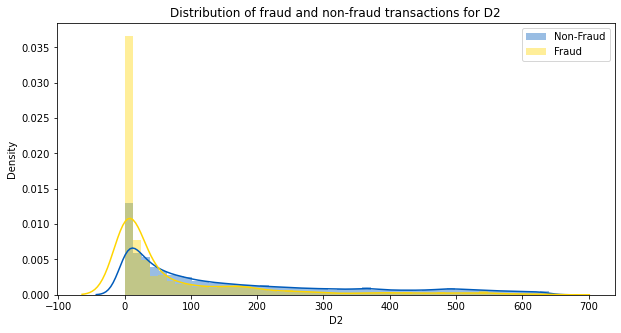

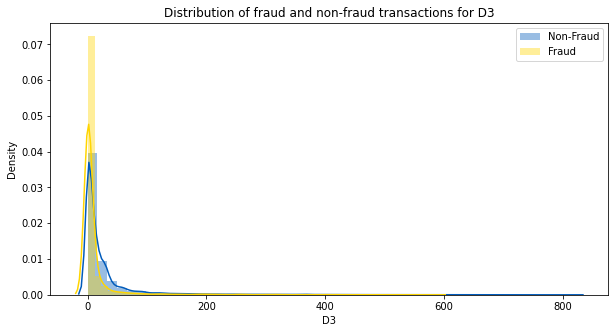

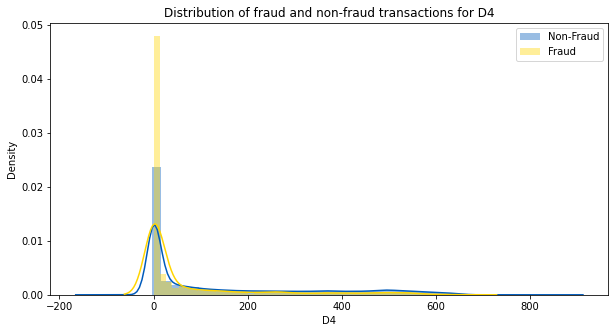

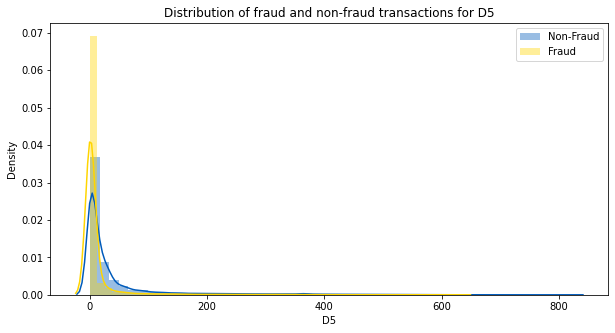

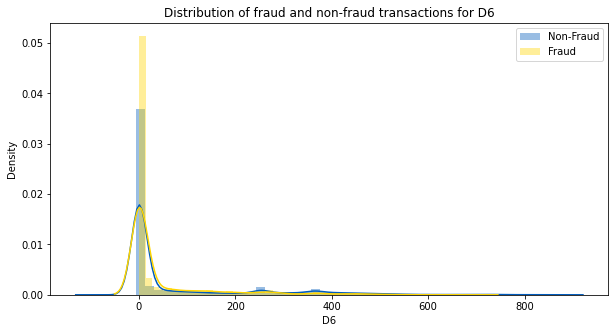

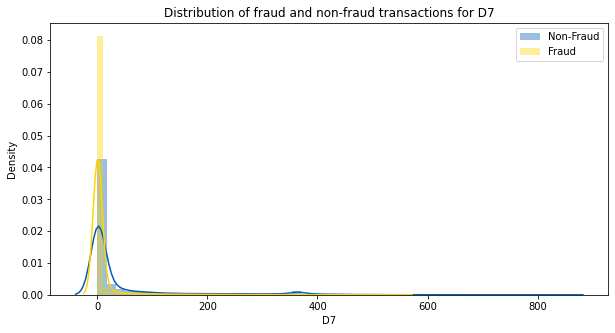

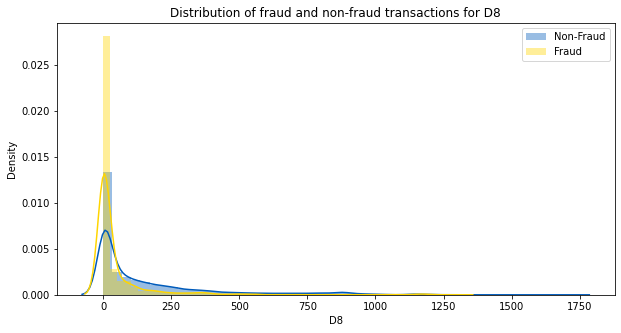

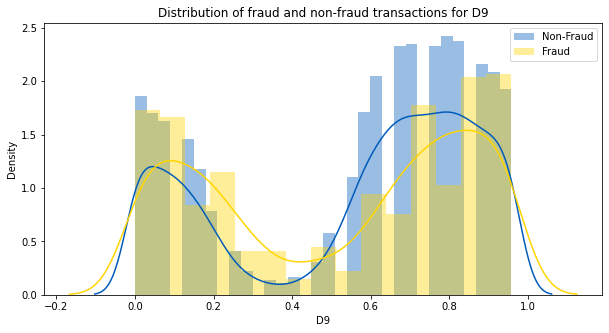

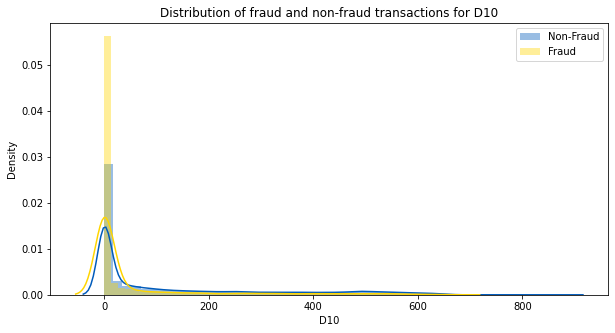

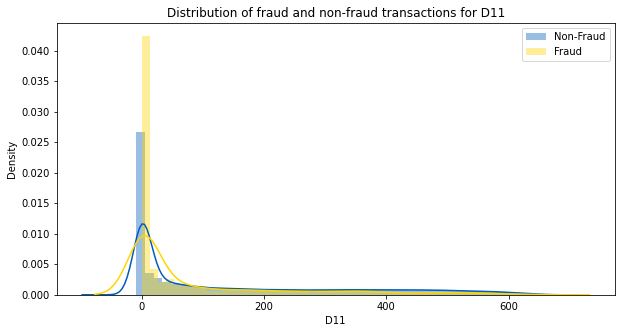

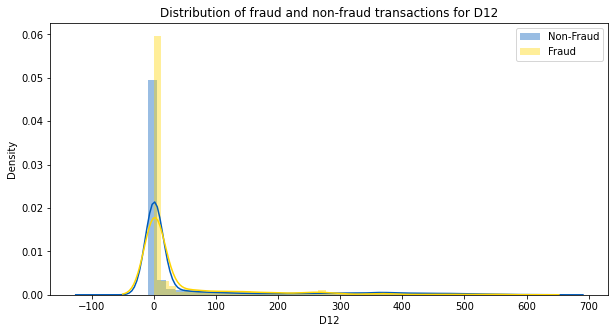

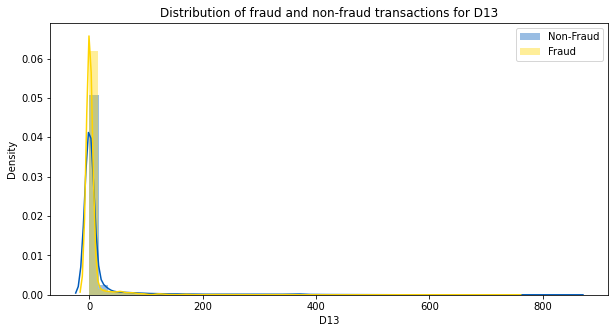

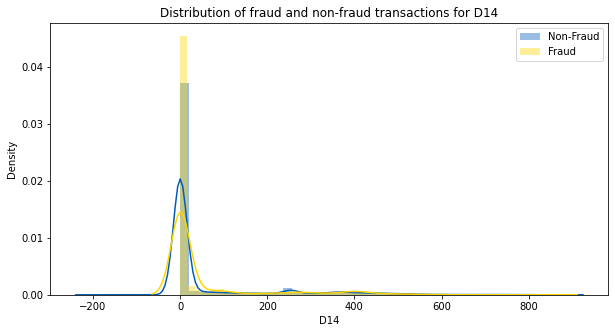

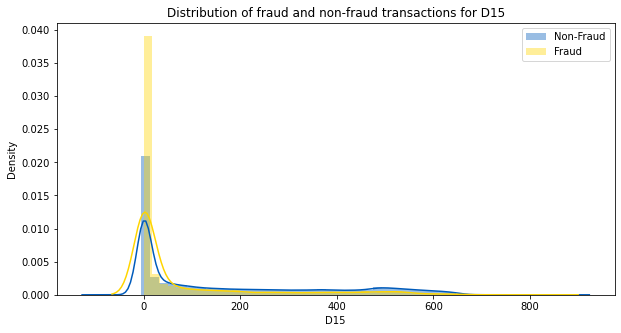

In [25]:
for col in df_d.columns:
    if col[0]=='D':
        plt.figure(figsize=(10,5))
        sns.distplot(df_d[(df_d['isFraud']==0)][col], color="#005BBB",label='Non-Fraud')
        sns.distplot(df_d[(df_d['isFraud']==1)][col], color="#FFD500",label='Fraud')
        plt.title("Distribution of fraud and non-fraud transactions for "+col)
        plt.legend()
        plt.show()

### Observations:
1) Columns D1,D2,D3,D5,D9 values are constant over TransactionDT very few outlier transactions D valuesare incresing with TransactionDT(time).
2) Remaining all D columns have increasing trend with respect to TransactionDT.
3) D8 column histogram distribution is matching with probability distribution of occurance of a transaction in a hour.

#### V1 to V399 features

In [30]:
'''dataframe with required columns are sent as arguments for below function
   return highly correlated column with correlation value > threshold and also plots heatmap
   and it uses corr() to get cor_matrix and i created upper triangular matrix with np.triu
   dot product with corelation matrix and upper triangularmatrix to eliminate all values below 
   and on the diognal otherwise all columns will be removed as value for every column at 
   diagnol is 1 > threshold 
'''
def corr_heatmap(dataframe,Plot=True,threshold=0.85):
    corr=dataframe.corr()
    cor_matrix = corr.abs()
    # cor_matrix=cor_matrix.fillna(0)
    upper_triangle_matrix=np.triu(np.ones(cor_matrix.shape), k=1)
    upper_triangle_matrix=cor_matrix*upper_triangle_matrix
    drop_cols=[cols for cols in upper_triangle_matrix.columns if any(upper_triangle_matrix[cols] > threshold)]
    if Plot:
        sns.set(rc={'figure.figsize': (25,25)})
        sns.heatmap(corr, cmap="RdBu_r", annot=False, linewidths=1,vmin = -1 , vmax = 1)
        plt.show()
    return drop_cols

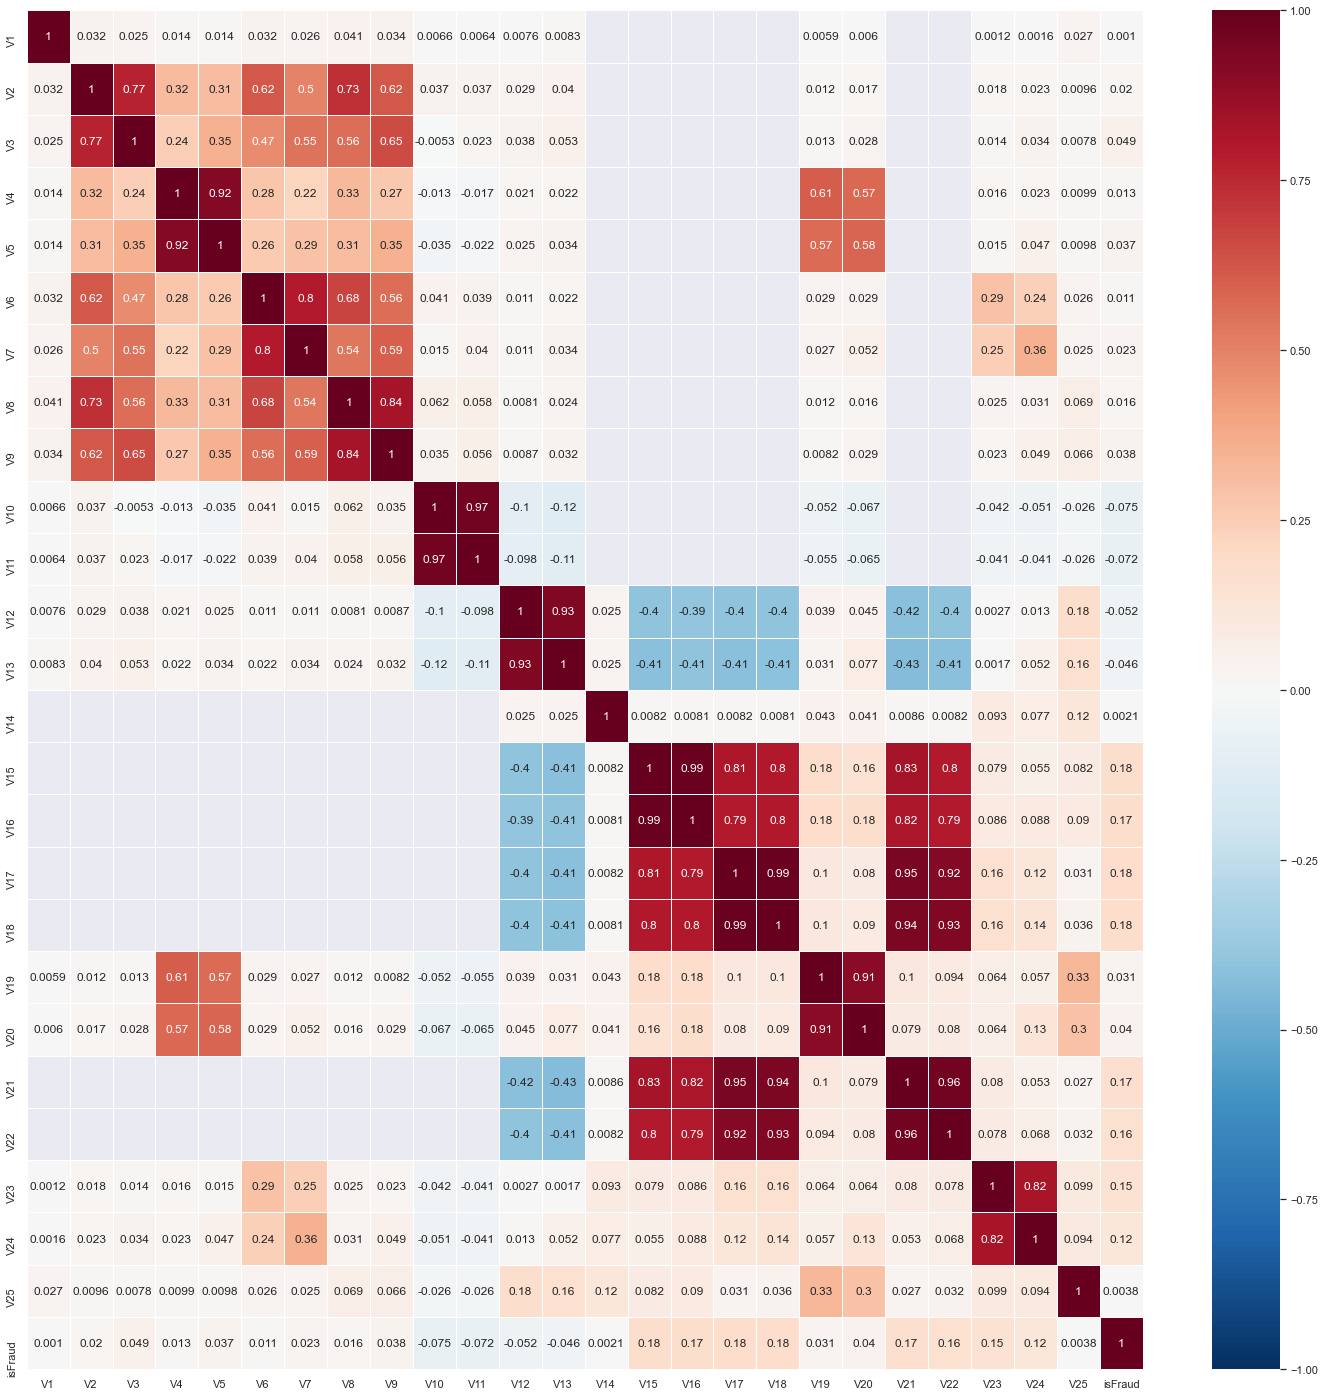

In [29]:
cols=[]
for i in range(1,26):
    v='V'+str(i)
    cols.append(v)
cols.append('isFraud')
drop_cols=corr_heatmap(df_train[cols],Plot=True)

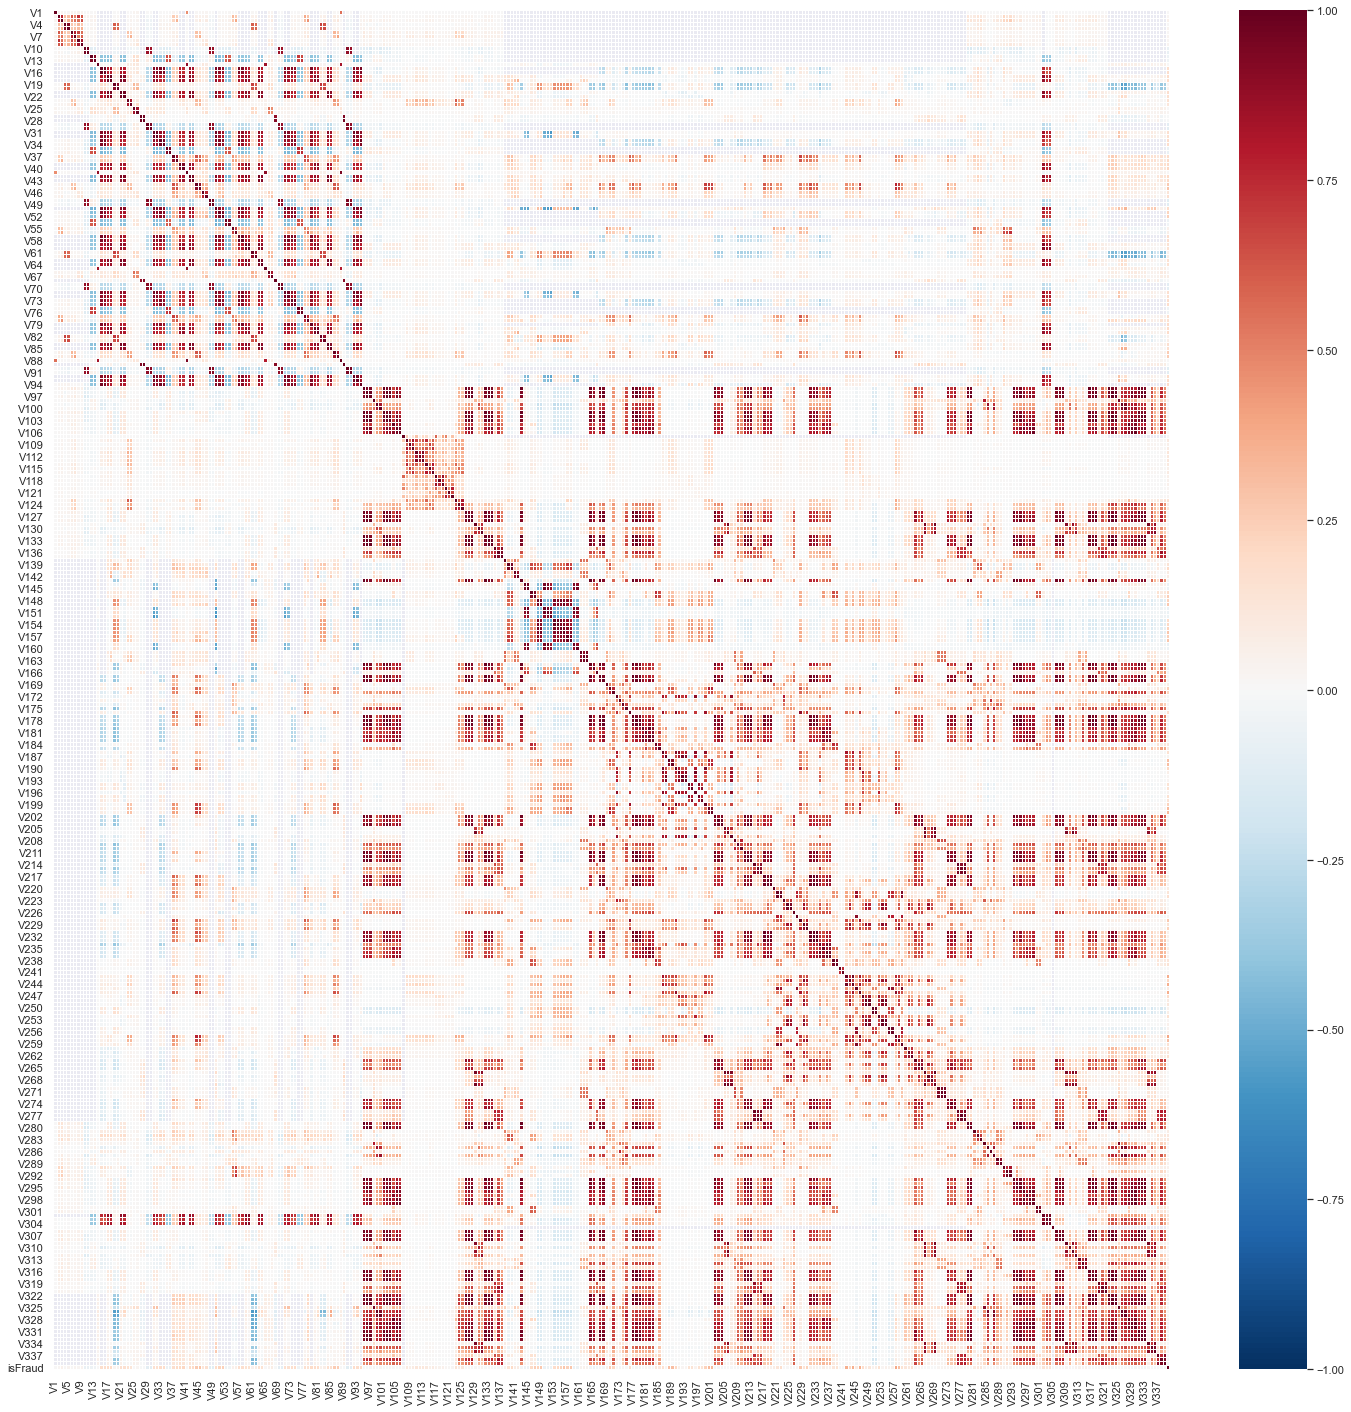

In [31]:
cols=[]
for i in range(1,340):
    v='V'+str(i)
    cols.append(v)
cols.append('isFraud')
drop_cols_v=corr_heatmap(df_train[cols],Plot=True)

In [40]:
print("The no_of inter dependent columns that need to be dropped from 339 V features are ",len(drop_cols_v))

The no_of inter dependent columns that need to be dropped from 339 V features are  215


### Observations:
1) V1toV339 features are Vesta(Dataset provider) engineered rich numerical features.
2) Most of V's contain Nan's and we are plotting correlation heatmaps between these 399 features with each other.
3) Highly correlated columns are removed by keeping a threshold of 0.85.
4) Out of 339 V columns 124 V columns were determined redundant by correlation analysis.

### C columns

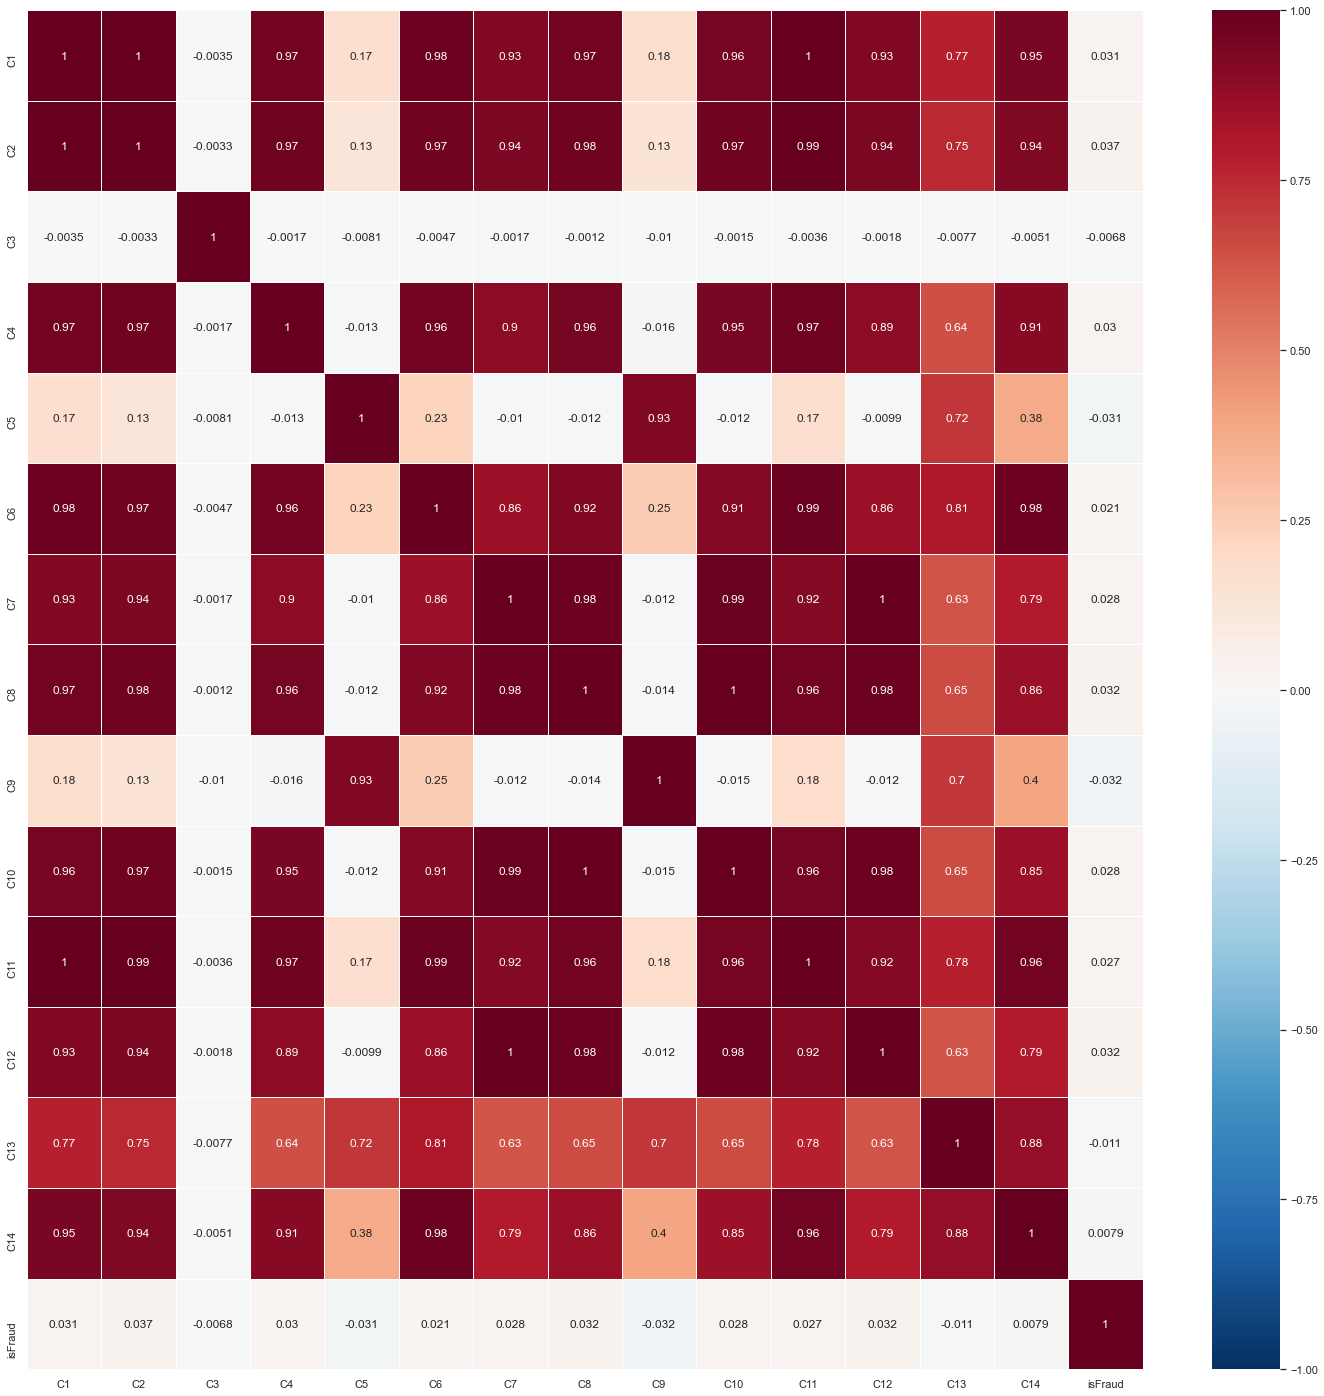

In [551]:
cols=[]
for i in range(1,15):
    c='C'+str(i)
    cols.append(c)
cols.append('isFraud')
drop_cols=corr_heatmap(df_train[cols],Plot=True)

### Observations:
1) C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
2) Most of the columns are highly interdepenent(high correlation values with each other)

### Observations:
1) All the id columns are independent except id_03 and id_09.
2) No redundant columns were identified by correlation analysis.

## **Prior Probability**
### Probability of occuring a transaction in a given hour :P(h)
**P(h)=No.of Transactions occured in a given hour/Total no of transaction in 24 hrs**

In [41]:
df_temp=df_train[['TransactionID','hour']].groupby(['hour']).agg({'TransactionID':'count'}).reset_index().rename(columns={'TransactionID':'No_of_transactions'})
df_temp['P(h)']=df_temp['No_of_transactions'].values/np.sum(df_temp['No_of_transactions'].values) 
df_temp=df_temp.rename(columns={'P(h)':'probofh'})

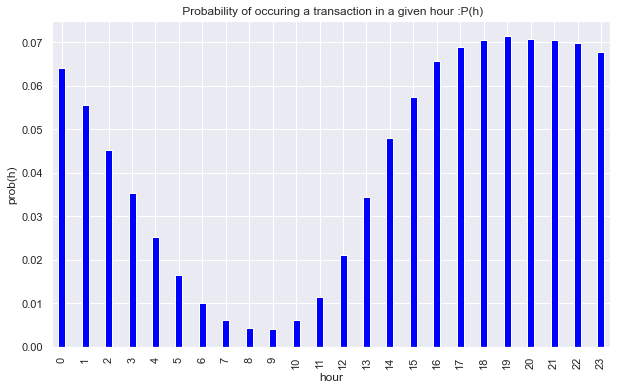

In [42]:
fig = plt.figure(figsize=(10,6)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
width = 0.3

df_temp.probofh.plot(kind='bar', color='blue', ax=ax, width=width)
ax.set_ylabel('prob(h)')
ax.set_xlabel('hour')
plt.title(' Probability of occuring a transaction in a given hour :P(h)')
plt.show()

## Bayes's Theorem 
$$P(h|F) = \frac{P(F|h) · P(h)}{P(F)}$$
## Conditional probability
$$P(h|F) = \frac{P((h=hour) and F)}{P(h=hour)}= \frac{n((h=hour) and F)}{n(h=hour)}$$
$$P(F|h) = \frac{P((h=hour) and F)}{P(F)}= \frac{n((h=hour) and F)}{n(F)}$$


In [43]:
df_temp_fraud=df_train.loc[df_train['isFraud']==1]
df_temp_fraud=df_temp_fraud[['TransactionID','hour']].groupby('hour').agg({'TransactionID':'count'}).reset_index().rename(columns={'TransactionID':'No_fraud_transactions'})
df_temp_fraud['No_of_transactions_in_an_h']=df_temp['No_of_transactions']
df_temp_fraud['No_of_non_fraud_tra_in_an_h']=df_temp_fraud['No_of_transactions_in_an_h']-df_temp_fraud['No_fraud_transactions']
df_temp_fraud['No_of_non_fraud_tra_in_an_h']=df_temp_fraud['No_of_transactions_in_an_h']-df_temp_fraud['No_fraud_transactions']
df_temp_fraud['Probofh']=df_temp['probofh']

In [44]:
df_temp_fraud['probhofF']=df_temp_fraud['No_fraud_transactions']/np.sum(df_temp_fraud['No_fraud_transactions'].values)
df_temp_fraud['probhofFc']=df_temp_fraud['No_of_non_fraud_tra_in_an_h']/np.sum(df_temp_fraud['No_of_non_fraud_tra_in_an_h'].values)
df_temp_fraud['probFofh']=df_temp_fraud['No_fraud_transactions']/df_temp_fraud['No_of_transactions_in_an_h']
Prob_F=np.sum(df_temp_fraud['No_fraud_transactions'].values)/np.sum(df_temp_fraud['No_of_transactions_in_an_h'].values)
Prob_Fc=1-Prob_F

In [45]:
df_temp_fraud['evidence']=df_temp_fraud['probhofF']*Prob_F+df_temp_fraud['probhofFc']*Prob_Fc

In [46]:
df_temp_fraud['ProbhgivenF']=df_temp_fraud['probFofh']*df_temp_fraud['Probofh']/df_temp_fraud['evidence']

In [47]:
df_temp_fraud.head()

hour  No_fraud_transactions  No_of_transactions_in_an_h  \
0     0                   1186                       37795   
1     1                   1027                       32797   
2     2                   1002                       26732   
3     3                    797                       20802   
4     4                    770                       14839   

   No_of_non_fraud_tra_in_an_h   Probofh  probhofF  probhofFc  probFofh  \
0                        36609  0.064001  0.057397   0.064240  0.031380   
1                        31770  0.055537  0.049702   0.055749  0.031314   
2                        25730  0.045267  0.048492   0.045150  0.037483   
3                        20005  0.035225  0.038571   0.035104  0.038314   
4                        14069  0.025128  0.037265   0.024688  0.051890   

   evidence  ProbhgivenF  
0  0.064001     0.031380  
1  0.055537     0.031314  
2  0.045267     0.037483  
3  0.035225     0.038314  
4  0.025128     0.051890

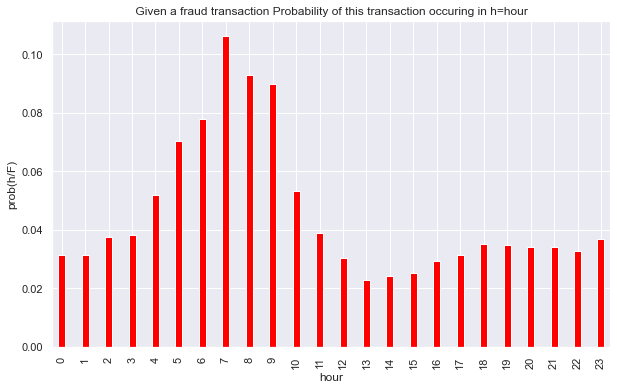

In [48]:
fig = plt.figure(figsize=(10,6)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
width = 0.3

df_temp_fraud[['hour','ProbhgivenF']].ProbhgivenF.plot(kind='bar', color='red', ax=ax, width=width)
ax.set_ylabel('prob(h/F)')
ax.set_xlabel('hour')
plt.title(' Given a fraud transaction Probability of this transaction occuring in h=hour ')
plt.show()

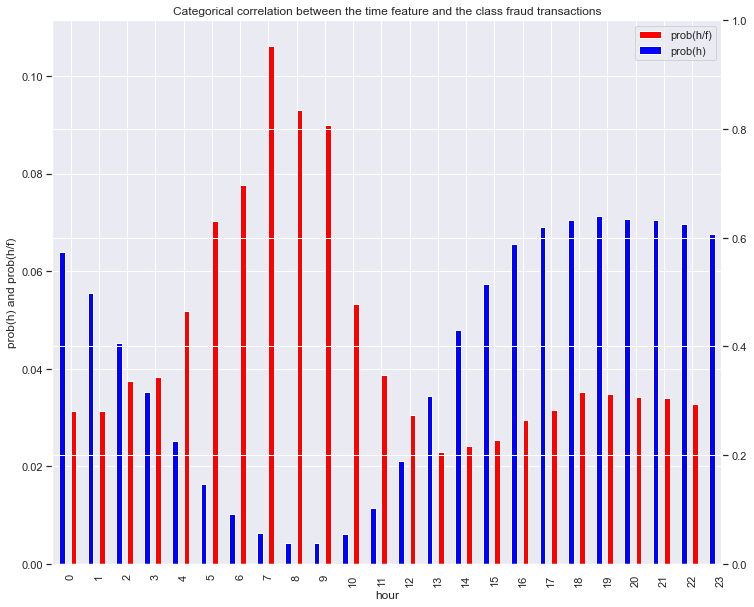

In [49]:
fig = plt.figure(figsize=(12,10)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
width = 0.2

df_temp_fraud[['hour','ProbhgivenF']].ProbhgivenF.plot(kind='bar', color='red', ax=ax, width=width, position=0,label='prob(h/f)')
df_temp.probofh.plot(kind='bar', color='blue', ax=ax, width=width, position=2,label='prob(h)')
ax.set_ylabel('prob(h) and prob(h/f)')
ax.set_xlabel('hour')
ax.legend()
plt.title('Categorical correlation between the time feature and the class fraud transactions')
plt.show()

### Observations:
1) The timing of the transactions is very important for detecting fraudulent
transactions. 
2) Here 0 to 24 does not represent the actual time 12 a.m to 12 p.m
3) Unsurprisingly, we observe that the total transactions occuring between hour 5 and 11 account for around 6% of the transactions (assuming the time as 12 a.m to 6 a.m and the shop are supposed to be closed) and for more than 40% of the fraudulent transactions.


## Distribution of fraudulent transactions over time

In [50]:
df_temp=df_train[['TransactionID','month','isFraud']].groupby(['month','isFraud']).agg({'TransactionID':'count'}).reset_index().rename(columns={'TransactionID':'counts'})
df_temp_fraud=df_temp.loc[df_temp['isFraud']==1]
df_temp_non_fraud=df_temp.loc[df_temp['isFraud']==0]
df_temp_non_fraud['ratio']=df_temp_non_fraud['counts'].values/df_temp_fraud['counts'].values

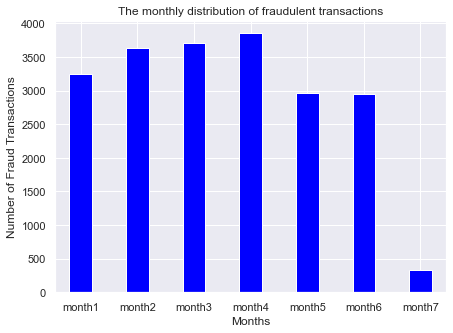

In [51]:
fig = plt.figure(figsize=(7,5)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
 
width = 0.4

df_temp_fraud.counts.plot(kind='bar', color='blue', ax=ax, width=width)

ax.set_ylabel('Number of Fraud Transactions')
ax.set_xlabel('Months')
ax.set_xticks(df_temp_fraud['month'].values)
ax.set_xticklabels(['month1','month2','month3','month4','month5','month6','month7'],rotation=0)
plt.title('The monthly distribution of fraudulent transactions')
plt.show()

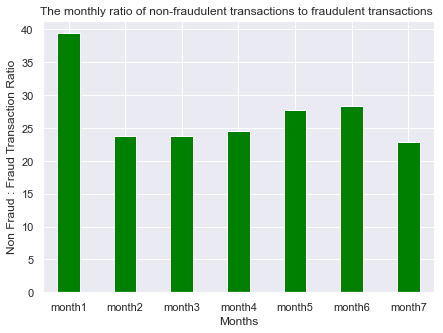

In [52]:
fig = plt.figure(figsize=(7,5)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
 
width = 0.4

df_temp_non_fraud.ratio.plot(kind='bar', color='green', ax=ax, width=width)

ax.set_ylabel('Non Fraud : Fraud Transaction Ratio')
ax.set_xlabel('Months')
ax.set_xticks(df_temp_fraud['month'].values)
ax.set_xticklabels(['month1','month2','month3','month4','month5','month6','month7'],rotation=0)
plt.title('The monthly ratio of non-fraudulent transactions to fraudulent transactions ')
plt.show()

### Observations:
1) Month 7 has only 2 days of transaction data so it has few fraud transactions.
2) As we are summing the behaviour over a month,except for month 1 most of the months have simillar non-fraud to fraud transaction ratio.
3) Both bar charts are less skewed.

In [53]:
# replacing inf values to nans
df_train.replace([np.inf, -np.inf], np.nan, inplace=True)
df_test.replace([np.inf, -np.inf], np.nan, inplace=True)
for column in df_train.columns:
    if column in drop_cols_v :
        df_train.drop(column, axis=1, inplace=True)
        df_test.drop(column, axis=1, inplace=True)

In [54]:
# Save data to pickle files for faster loading
df_train.to_pickle('df_train.pkl')
df_test.to_pickle('df_test.pkl')